In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, seaborn as sns
from sklearn.linear_model import LinearRegression
plt.rcParams.update({'font.size': 14})

In [2]:
data_dir = '../../../datasets/ppmi/visit_feature_inputs_asof_2019Jan24_using_CMEDTM/'
pd_total_df = pd.read_csv(data_dir + 'PD_totals_across_time.csv')

In [3]:
pd_total_df.columns.values

array(['PATNO', 'EVENT_ID', 'SCOPA-AUT', 'HVLT_discrim_recog',
       'HVLT_immed_recall', 'NUPDRS3_untreated', 'QUIP', 'NUPDRS3_on',
       'EPWORTH', 'STATE_ANXIETY', 'NUPDRS3_off', 'GDSSHORT', 'NUPDRS1',
       'NUPDRS2', 'HVLT_retent', 'BJLO', 'MOCA', 'LNS', 'TRAIT_ANXIETY',
       'SEMANTIC_FLUENCY', 'NUPDRS3_maob', 'REMSLEEP', 'NUPDRS4',
       'INFODT', 'INFODT_DIS_DUR', 'INFODT_TIME_SINCE_ENROLL',
       'EVENT_ID_DUR', 'DIS_DUR_BY_CONSENTDT'], dtype=object)

### Select 20 patients to use for visualizations

In [4]:
np.random.seed(82073)
patnos = pd_total_df.PATNO.unique()
np.random.shuffle(patnos)
selected_patnos = np.empty(20)
idx = 0
for patno in patnos:
    if idx == 20:
        break
    patno_df = pd_total_df.loc[pd_total_df['PATNO']==patno]
    patno_df = patno_df.dropna(subset=['NUPDRS3_untreated', 'NUPDRS3_off', 'NUPDRS3_on'], \
                               how='all').sort_values(by=['EVENT_ID_DUR'])
    if len(patno_df) >= 5:
        selected_patnos[idx] = patno
        idx += 1
selected_patnos

array([3589., 3471., 3312., 3954., 3831., 3705., 3083., 3225., 3972.,
       3476., 3970., 3567., 4073., 3023., 4096., 3178., 3010., 3629.,
       3556., 3869.])

### Plot MDS-UPDRS III untreated vs off vs on vs MAO-B inhibitor

In [5]:
def make_plots_4treatment_cond(pd_totals_df, col_header, selected_patnos, xlim=None, ylim=None):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))#, sharex=True, sharey=True)
    if xlim is not None:
        for i in range(2):
            for j in range(5):
                ax[i,j].set_xlim(xlim) # want labels on each axis
    if ylim is not None:
        for i in range(2):
            for j in range(5):
                ax[i,j].set_ylim(ylim)
    idx = 0
    for patno in selected_patnos:
        patno_df = pd_totals_df.loc[pd_totals_df['PATNO']==patno]
        patno_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_off',col_header+'_on', \
                                           col_header + '_maob'],\
                                   how='all').sort_values(by=['EVENT_ID_DUR'])
            
        untreated_df = patno_df.dropna(subset=[col_header+'_untreated'])
        untreated_times = untreated_df.EVENT_ID_DUR.values
        untreated_values = untreated_df[col_header+'_untreated'].values
        if len(untreated_times) > 0:
            ax[int(idx/5), int(idx%5)].scatter(untreated_times, untreated_values, c='b', label='untreated')
            if len(untreated_times) > 1:
                untreated_linreg = LinearRegression().fit(untreated_times.reshape(-1,1), untreated_values)
                ax[int(idx/5), int(idx%5)].plot(untreated_times, untreated_linreg.predict(untreated_times.reshape(-1, 1)), 'b')
        
        off_df = patno_df.dropna(subset=[col_header+'_off'])
        off_times = off_df.EVENT_ID_DUR.values
        off_values = off_df[col_header+'_off'].values
        if len(off_times) > 0:
            ax[int(idx/5), int(idx%5)].scatter(off_times, off_values, c='g', label='"off" meds')
            if len(off_times) > 1:
                off_linreg = LinearRegression().fit(off_times.reshape(-1,1), off_values)
                ax[int(idx/5), int(idx%5)].plot(off_times, off_linreg.predict(off_times.reshape(-1, 1)), 'g')
        
        on_df = patno_df.dropna(subset=[col_header+'_on'])
        on_times = on_df.EVENT_ID_DUR.values
        on_values = on_df[col_header+'_on'].values
        if len(on_times) > 0:
            ax[int(idx/5), int(idx%5)].scatter(on_times, on_values, c='r', label='"on" meds')
            if len(on_times) > 1:
                on_linreg = LinearRegression().fit(on_times.reshape(-1,1), on_values)
                ax[int(idx/5), int(idx%5)].plot(on_times, on_linreg.predict(on_times.reshape(-1, 1)), 'r')
        maob_df = patno_df.dropna(subset=[col_header+'_maob'])
        maob_times = maob_df.EVENT_ID_DUR.values
        maob_values = maob_df[col_header+'_maob'].values
        if len(maob_times) > 0:
            ax[int(idx/5), int(idx%5)].scatter(maob_times, maob_values, c='y', label='MAO-B')
        idx += 1
    plt.legend()
    plt.tight_layout()
    plt.suptitle(col_header)
    plt.show()

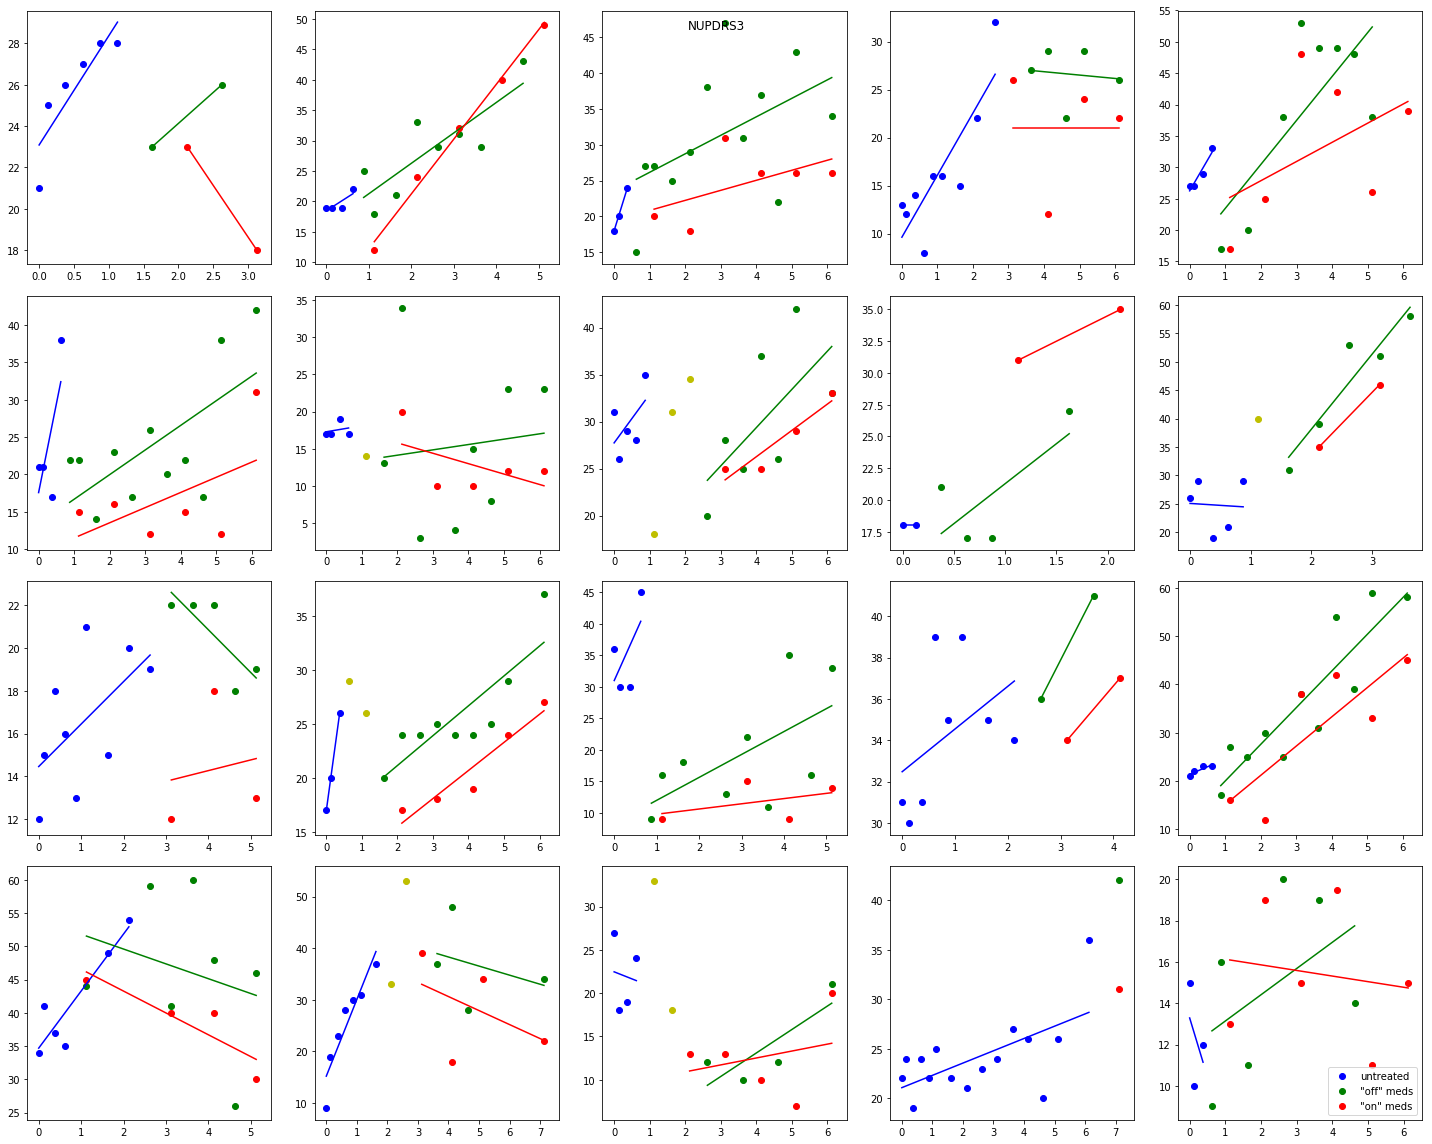

In [6]:
make_plots_4treatment_cond(pd_total_df, 'NUPDRS3', selected_patnos)

In [5]:
pd_questions_df = pd.read_csv(data_dir + 'PD_questions_across_time.csv')
pd_questions_df.columns.values

array(['PATNO', 'EVENT_ID', 'NP3PTRML_untreated', 'TMEAT', 'NP3RIGLU_off',
       'NP3PSTBL_on', 'NP3LGAGL_untreated', 'NP3FACXP_off', 'STAIAD25',
       'NP3RTCON_maob', 'STAIAD19', 'STAIAD18', 'STAIAD17', 'STAIAD16',
       'STAIAD15', 'STAIAD14', 'STAIAD13', 'STAIAD12', 'STAIAD11',
       'NP3RIGLU_on', 'NP1URIN', 'LNS7A', 'NP3PRSPL_untreated', 'LNS7C',
       'LNS7B', 'BJLOT5', 'NP3RIGRL_off', 'BJLOT7', 'BJLOT6', 'BJLOT1',
       'BJLOT3', 'BJLOT2', 'BJLOT9', 'BJLOT8', 'GDSAFRAD', 'CNTRLSEX',
       'NP3KTRML_off', 'NP3FTAPR_maob', 'MCARHINO', 'NP3LGAGL_on',
       'NP3RIGLL_untreated', 'NP4FLCTX', 'NP4FLCTI', 'HETRA',
       'NP3RTARU_off', 'NP3FTAPR_off', 'NP3POSTR_on', 'CNTRLDSM',
       'NP3HMOVR_on', 'NP3RTCON_off', 'NP2DRES', 'NP4DYSKI',
       'NP3PRSPL_off', 'TMSEX', 'GDSHOPLS', 'GDSHLPLS', 'NP3RTALJ_on',
       'MCADATE', 'NP3LGAGR_on', 'RLS', 'MVAWAKEN', 'NP3TTAPR_on',
       'LNS3A', 'LNS3C', 'LNS3B', 'NP3PRSPL_maob', 'NP3RIGN_maob',
       'GDSHAPPY', 'NP3SPCH_off', 'GD

### Merge other medication data?

In [6]:
treatment_dir = '../../../datasets/ppmi/treatment_pipeline_output_asof_2019Jan24/'
pd_prior_treatment_df = pd.read_csv(treatment_dir + 'PD_treatment_before_first_visit.csv')
pd_treatment_df = pd.read_csv(treatment_dir + 'PD_treatment_between_visits.csv')

In [9]:
with pd.option_context('display.max_columns', None):
    display(pd_prior_treatment_df.head())
    display(pd_treatment_df.head())

,PATNO,EVENT_ID,INFODT,THYROID,ANESTHETIC,IMMUNOSUPPRESSANT,ANTIEMETIC,ANTIHYPERTENSIVE,ANTIPSYCHOTIC,ANTIHISTAMINE,CONTRACEPTIVE,SLEEP AID,MOOD STABILIZER,ANTI BPH,SUPPLEMENT,NEUROTOXIN,ANALGESIC,ANTIINFLAMMATORY,ANTIHYPERLIPIDEMIC,ANTIARRHYTHMIC,NSAID,DERMATOLOGIC,ANTIHYPOTENSIVE,ANTIDIARRHEAL,PD SUPPLEMENT,STIMULANT,RARE_CLASS,ANTICANCER,ANTITHYROID AGENT,COGNITIVE ENHANCER,ANTIFUNGAL,OPTHALAMIC,HORMONE REPLACEMENT,ANTIBIOTIC,ANTITREMOR,DOPAMINE REPLACEMENT,ANTISPASMODIC,DECONGESTANT,DIGESTIVE AID,BONE/JOINT HEALTH,OTHER,ANTICONVULSANT,ANXIOLYTIC,MUCOLYTIC,ANTIGLAUCOMA,MUSCLE RELAXER,BLADDER CONTROL,ANTIDEPRESSANT,URIC ACID REDUCER,ANTIHYPERGLYCEMIC,VACCINE,ANTICOAGULANT/BLOOD THINNER,ADRENALCORTICAL REPLACEMENT,BRONCHODILATOR,ANTACID,THYROID HORMONE,ANTIVIRAL,VASODILATOR
0,3001,SC,2011-02-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3002,SC,2011-03-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3003,SC,2011-03-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,3006,SC,2011-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,3007,SC,2011-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


,PATNO,EVENT_ID,INFODT,THYROID,ANESTHETIC,IMMUNOSUPPRESSANT,ANTIEMETIC,ANTIHYPERTENSIVE,ANTIPSYCHOTIC,ANTIHISTAMINE,CONTRACEPTIVE,SLEEP AID,MOOD STABILIZER,ANTI BPH,SUPPLEMENT,NEUROTOXIN,ANALGESIC,ANTIINFLAMMATORY,ANTIHYPERLIPIDEMIC,ANTIARRHYTHMIC,NSAID,DERMATOLOGIC,ANTIHYPOTENSIVE,ANTIDIARRHEAL,PD SUPPLEMENT,STIMULANT,RARE_CLASS,ANTICANCER,ANTITHYROID AGENT,COGNITIVE ENHANCER,ANTIFUNGAL,OPTHALAMIC,HORMONE REPLACEMENT,ANTIBIOTIC,ANTITREMOR,DOPAMINE REPLACEMENT,ANTISPASMODIC,DECONGESTANT,DIGESTIVE AID,BONE/JOINT HEALTH,OTHER,ANTICONVULSANT,ANXIOLYTIC,MUCOLYTIC,ANTIGLAUCOMA,MUSCLE RELAXER,BLADDER CONTROL,ANTIDEPRESSANT,URIC ACID REDUCER,ANTIHYPERGLYCEMIC,VACCINE,ANTICOAGULANT/BLOOD THINNER,ADRENALCORTICAL REPLACEMENT,BRONCHODILATOR,ANTACID,THYROID HORMONE,ANTIVIRAL,VASODILATOR
0,3001,SC,2011-02-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3001,BL,2011-03-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3001,V01,2011-05-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3001,V02,2011-08-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3001,V03,2011-11-01,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
treatments_of_interest = ['DOPAMINE REPLACEMENT', 'ANTICONVULSANT',  'ANTITREMOR',  'ANTISPASMODIC', \
                          'MUSCLE RELAXER', 'ANXIOLYTIC', 'MOOD STABILIZER', 'COGNITIVE ENHANCER']
pd_questions_df = pd_questions_df.merge(pd_treatment_df[['PATNO','EVENT_ID'] + treatments_of_interest], \
                                        on=['PATNO','EVENT_ID'], how='left', validate='one_to_one')

### Plot subtotals across time colored by treatment

In [8]:
def get_4cond_cols(cols):
    # returns untreated, off, on, maob
    untreated_cols = []
    off_cols = []
    on_cols = []
    maob_cols = []
    for col in cols:
        if col.startswith('NP3'):
            untreated_cols.append(col+'_untreated')
            off_cols.append(col+'_off')
            on_cols.append(col+'_on')
            maob_cols.append(col+'_maob')
        else:
            untreated_cols.append(col)
            off_cols.append(col)
            on_cols.append(col)
            maob_cols.append(col)
    return untreated_cols, off_cols, on_cols, maob_cols

In [9]:
def get_cond_sum(df, cols, sum_col):
    df[sum_col] = np.where(pd.isnull(df[cols[0]]), float('NaN'), df[cols].sum(axis=1))
    return df

In [10]:
tremor_cols = ['NP3RTALL', 'NP3RTALU', 'NP3KTRML', 'NP3PTRML', 'NP3KTRMR', 'NP3PTRMR', 'NP3RTARU', \
                   'NP3RTALJ', 'NP3RTARL', 'NP2TRMR', 'NP3RTCON']
tremor_untreated_cols, tremor_off_cols, tremor_on_cols, tremor_maob_cols = get_4cond_cols(tremor_cols)
pd_questions_df = get_cond_sum(pd_questions_df, tremor_untreated_cols, 'NUPDRS_TREMOR_untreated')
pd_questions_df = get_cond_sum(pd_questions_df, tremor_off_cols, 'NUPDRS_TREMOR_off')
pd_questions_df = get_cond_sum(pd_questions_df, tremor_on_cols, 'NUPDRS_TREMOR_on')
pd_questions_df = get_cond_sum(pd_questions_df, tremor_maob_cols, 'NUPDRS_TREMOR_maob')

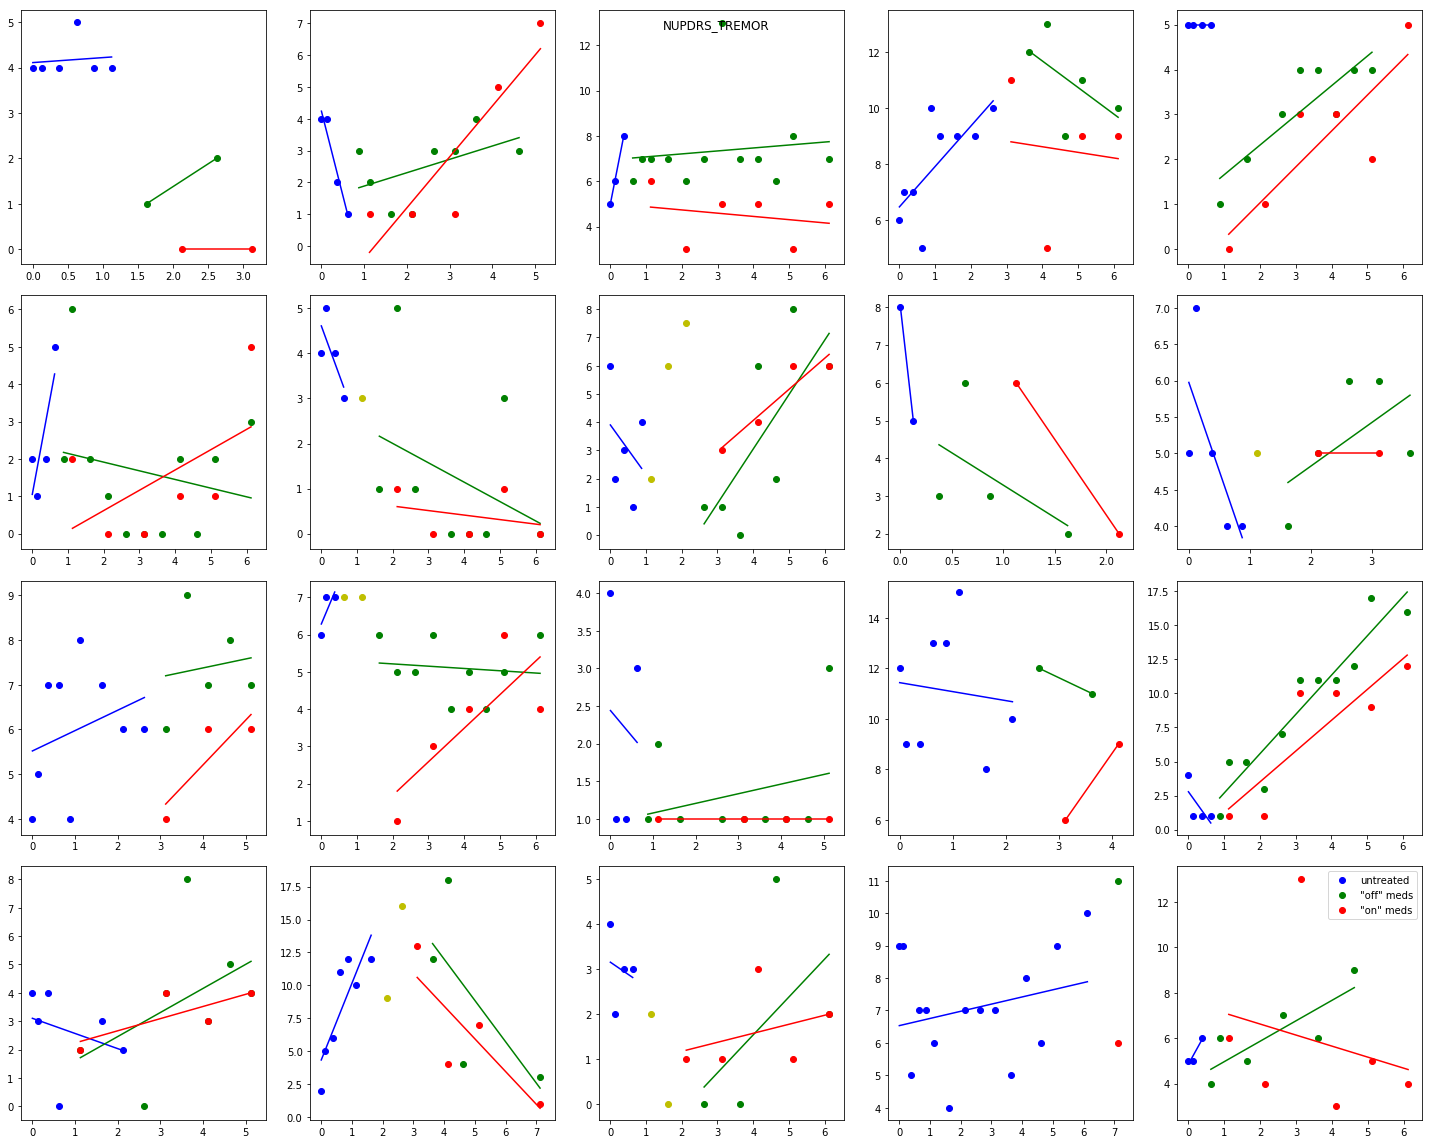

In [14]:
make_plots_4treatment_cond(pd_questions_df, 'NUPDRS_TREMOR', selected_patnos)

In [11]:
rigidity_left_cols = ['NP3RIGLU', 'NP3RIGLL', 'NP3PRSPL', 'NP3FTAPL', 'NP3HMOVL', 'NP3LGAGL', 'NP3TTAPL']
rigidity_left_untreated_cols, rigidity_left_off_cols, rigidity_left_on_cols, rigidity_left_maob_cols \
    = get_4cond_cols(rigidity_left_cols)
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_left_untreated_cols, 'NUPDRS_RIGIDITY_LEFT_untreated')
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_left_off_cols, 'NUPDRS_RIGIDITY_LEFT_off')
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_left_on_cols, 'NUPDRS_RIGIDITY_LEFT_on')
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_left_maob_cols, 'NUPDRS_RIGIDITY_LEFT_maob')

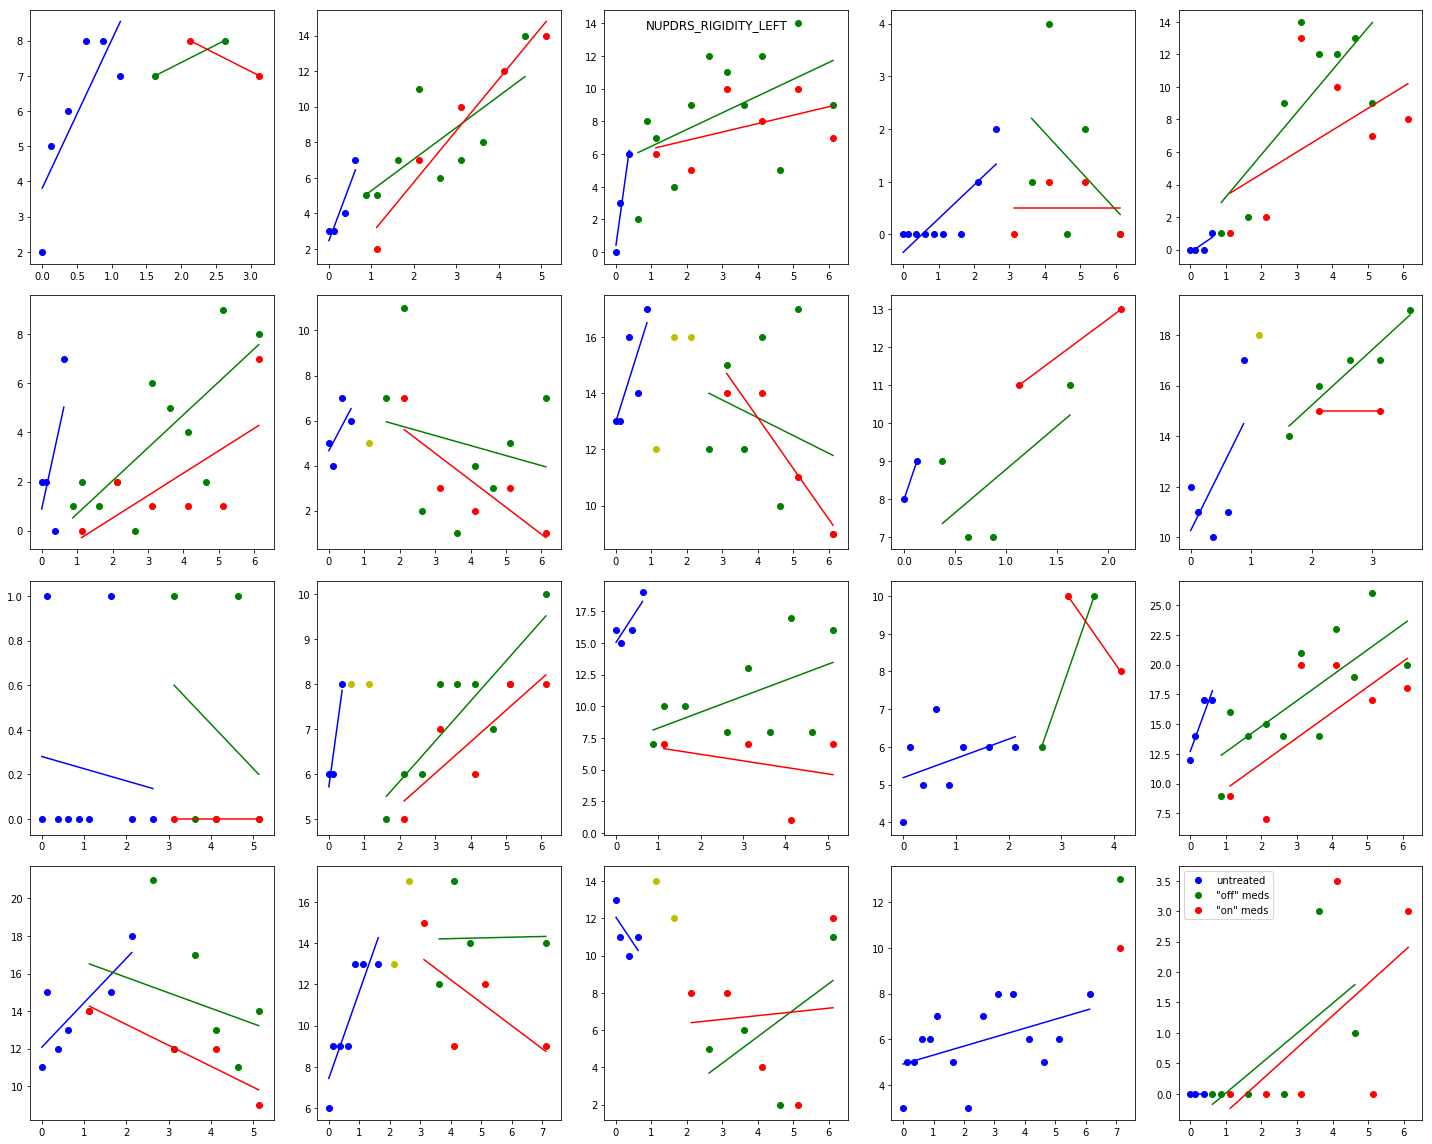

In [16]:
make_plots_4treatment_cond(pd_questions_df, 'NUPDRS_RIGIDITY_LEFT', selected_patnos)

In [12]:
rigidity_right_cols = ['NP3RIGRL', 'NP3RIGRU', 'NP3PRSPR', 'NP3FTAPR', 'NP3HMOVR', 'NP3LGAGR', 'NP3TTAPR']
rigidity_right_untreated_cols, rigidity_right_off_cols, rigidity_right_on_cols, rigidity_right_maob_cols \
    = get_4cond_cols(rigidity_right_cols)
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_right_untreated_cols, 'NUPDRS_RIGIDITY_RIGHT_untreated')
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_right_off_cols, 'NUPDRS_RIGIDITY_RIGHT_off')
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_right_on_cols, 'NUPDRS_RIGIDITY_RIGHT_on')
pd_questions_df = get_cond_sum(pd_questions_df, rigidity_right_maob_cols, 'NUPDRS_RIGIDITY_RIGHT_maob')

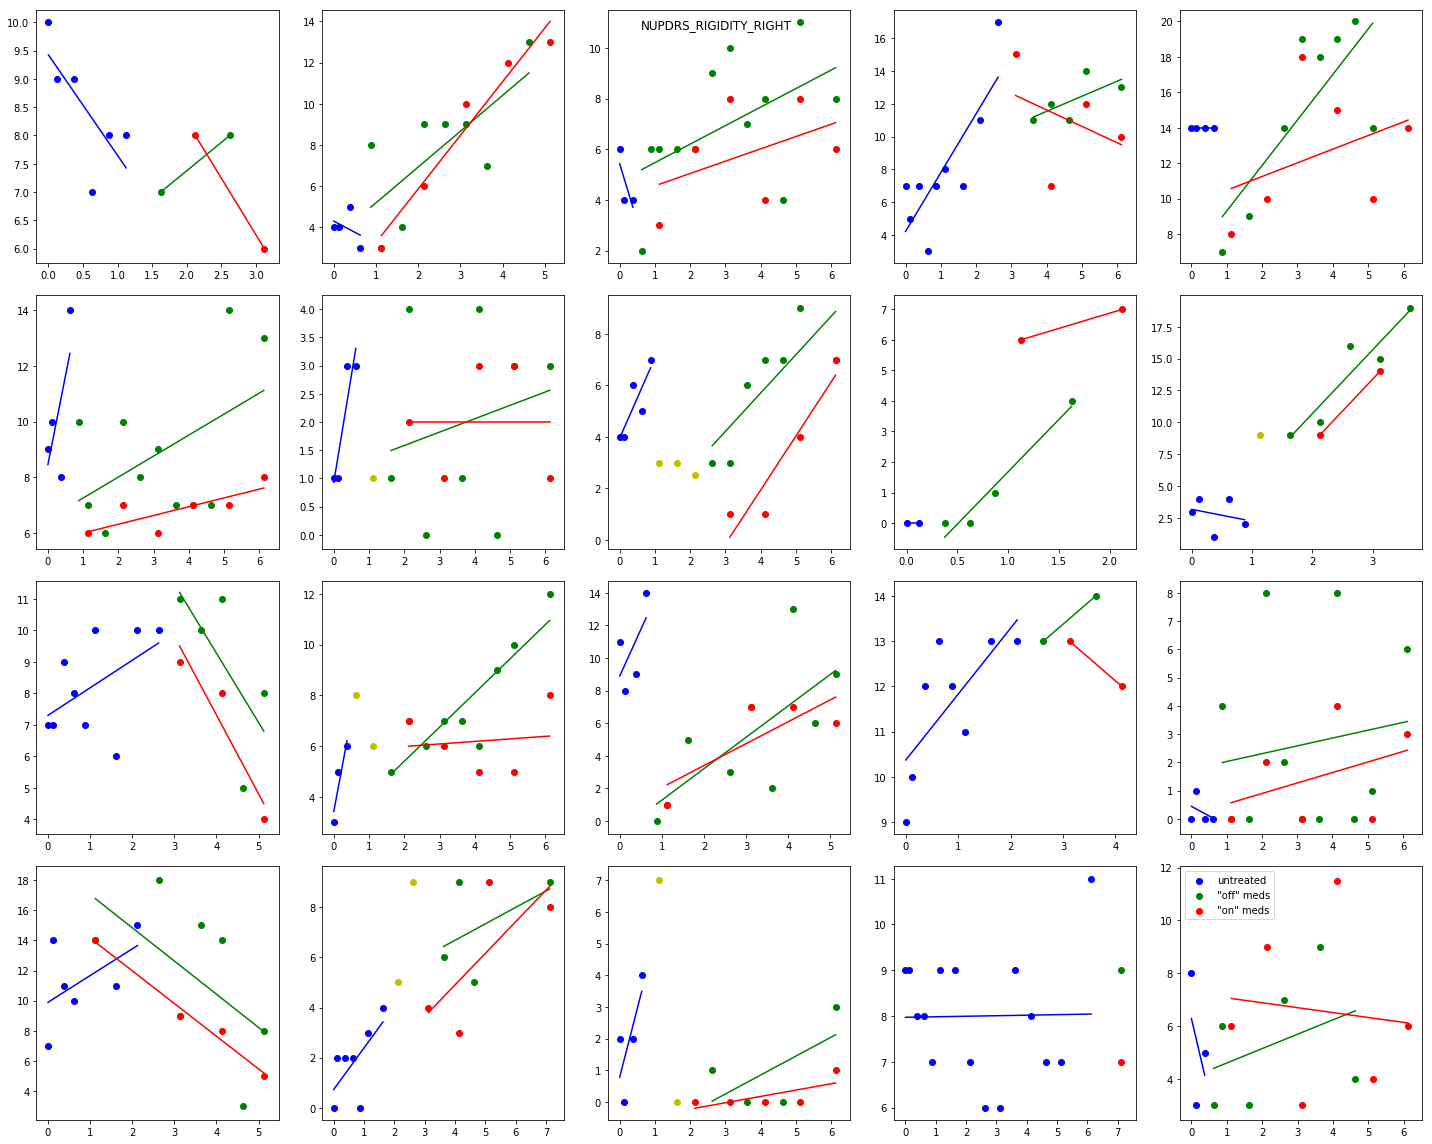

In [18]:
make_plots_4treatment_cond(pd_questions_df, 'NUPDRS_RIGIDITY_RIGHT', selected_patnos)

In [13]:
face_cols = ['NP3SPCH', 'NP3RIGN', 'NP3BRADY', 'NP3FACXP']
face_untreated_cols, face_off_cols, face_on_cols, face_maob_cols = get_4cond_cols(face_cols)
pd_questions_df = get_cond_sum(pd_questions_df, face_untreated_cols, 'NUPDRS_FACE_untreated')
pd_questions_df = get_cond_sum(pd_questions_df, face_off_cols, 'NUPDRS_FACE_off')
pd_questions_df = get_cond_sum(pd_questions_df, face_on_cols, 'NUPDRS_FACE_on')
pd_questions_df = get_cond_sum(pd_questions_df, face_maob_cols, 'NUPDRS_FACE_maob')

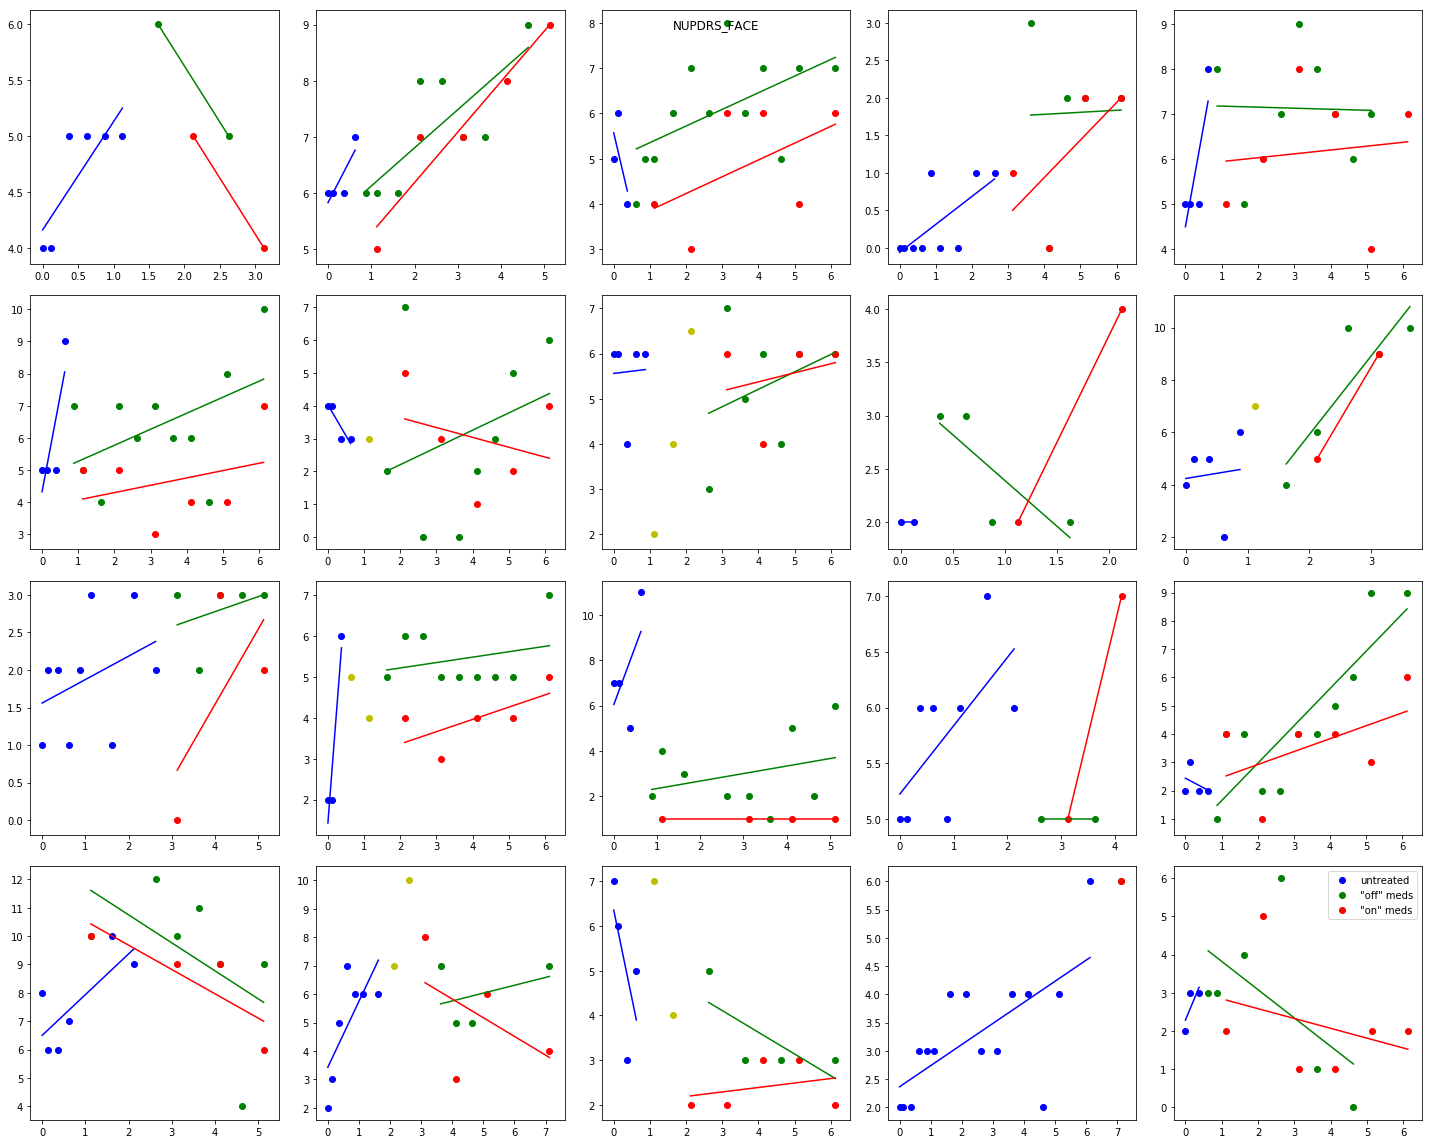

In [20]:
make_plots_4treatment_cond(pd_questions_df, 'NUPDRS_FACE', selected_patnos)

In [14]:
gait_cols = ['NP3FRZGT', 'NP3PSTBL', 'NP3RISNG', 'NP3GAIT', 'NP3POSTR']
gait_untreated_cols, gait_off_cols, gait_on_cols, gait_maob_cols = get_4cond_cols(gait_cols)
pd_questions_df = get_cond_sum(pd_questions_df, gait_untreated_cols, 'NUPDRS_GAIT_untreated')
pd_questions_df = get_cond_sum(pd_questions_df, gait_off_cols, 'NUPDRS_GAIT_off')
pd_questions_df = get_cond_sum(pd_questions_df, gait_on_cols, 'NUPDRS_GAIT_on')
pd_questions_df = get_cond_sum(pd_questions_df, gait_maob_cols, 'NUPDRS_GAIT_maob')

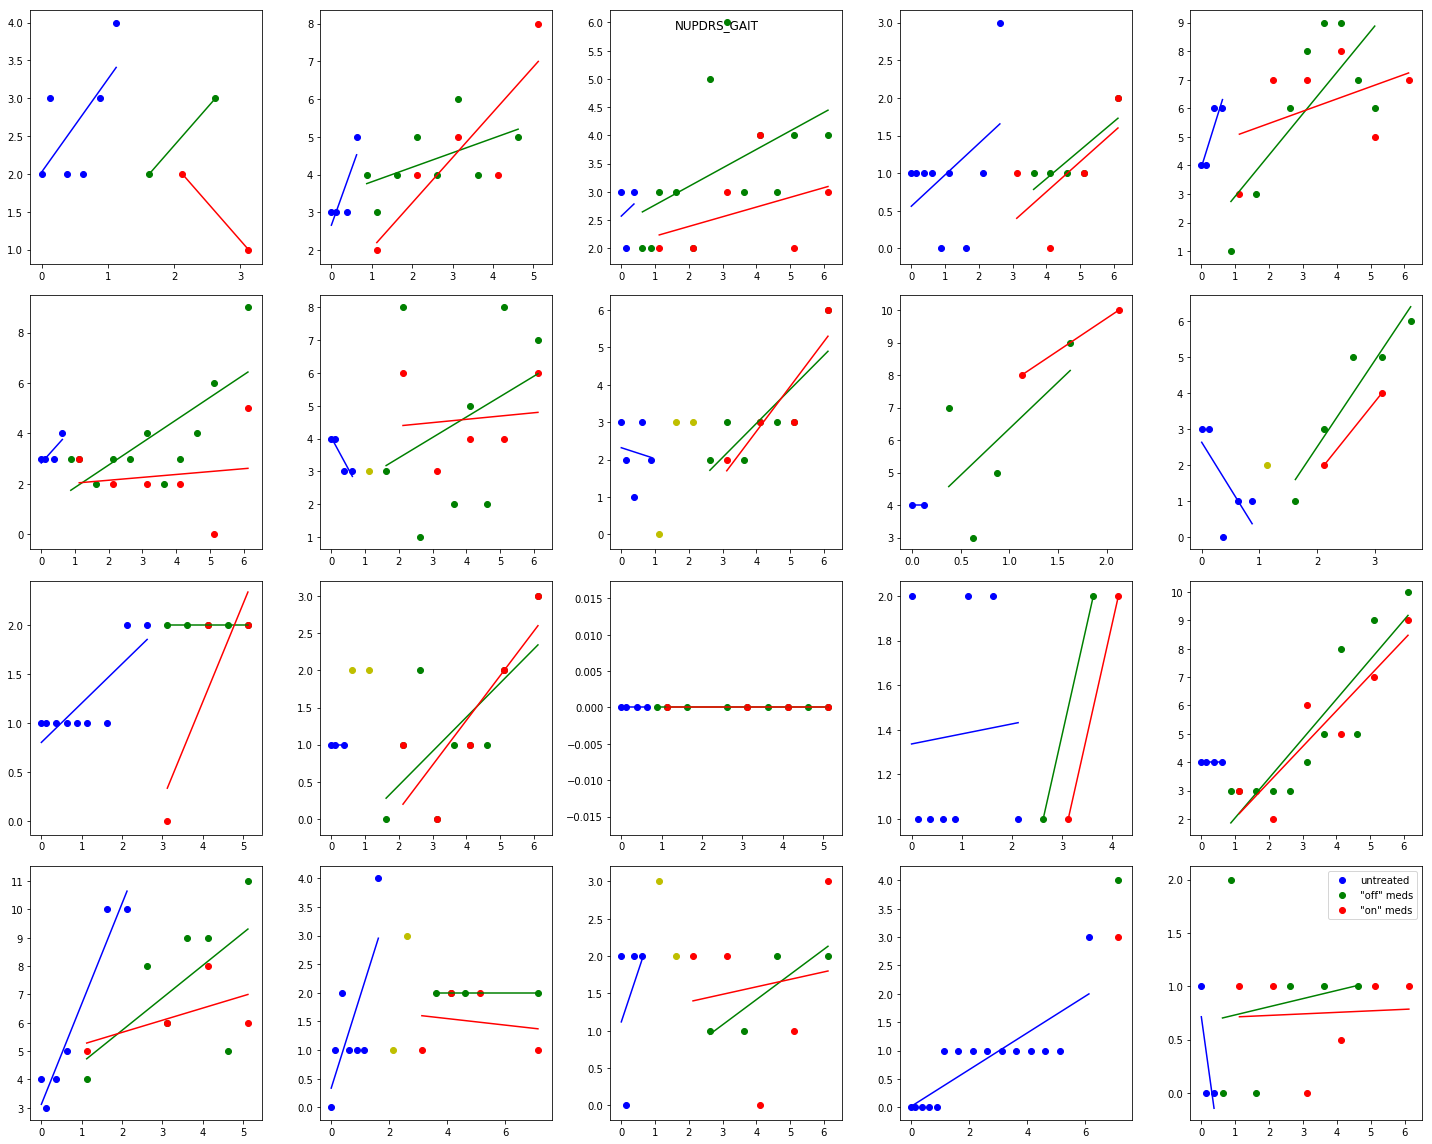

In [22]:
make_plots_4treatment_cond(pd_questions_df, 'NUPDRS_GAIT', selected_patnos)

In [15]:
def get_on_off_sums(df, cols, med_cols, sum_header):
    df[sum_header + '_untreated'] = np.where(df[med_cols].sum(axis=1) == 0, df[cols].sum(axis=1), float('NaN'))
    df[sum_header + '_treated'] = np.where(df[med_cols].sum(axis=1) == 0, float('NaN'), df[cols].sum(axis=1))
    return df

In [16]:
daily_activities = ['NP2HWRT', 'NP2FREZ', 'NP2HYGN', 'NP2EAT', 'NP2HOBB', 'NP2WALK', 'NP2DRES', 'NP2RISE', \
                    'NP2TURN', 'NP2SWAL', 'NP2SALV', 'NP2SPCH']
dopamine_med_cols = ['DOPAMINE REPLACEMENT']
pd_questions_df = get_on_off_sums(pd_questions_df, daily_activities, dopamine_med_cols, 'NUPDRS_DAILYACT_DOPA')
motor_med_cols = ['DOPAMINE REPLACEMENT', 'ANTICONVULSANT', 'ANTITREMOR', 'ANTISPASMODIC', 'MUSCLE RELAXER']
pd_questions_df = get_on_off_sums(pd_questions_df, daily_activities, motor_med_cols, 'NUPDRS_DAILYACT_MOTOR')

In [25]:
def make_plots_2treatment_cond(pd_totals_df, col_header, selected_patnos, xlim=None, ylim=None):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))#, sharex=True, sharey=True)
    if xlim is not None:
        for i in range(2):
            for j in range(5):
                ax[i,j].set_xlim(xlim) # want labels on each axis
    if ylim is not None:
        for i in range(2):
            for j in range(5):
                ax[i,j].set_ylim(ylim)
    idx = 0
    for patno in selected_patnos:
        patno_df = pd_totals_df.loc[pd_totals_df['PATNO']==patno]
        patno_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_treated'], \
                                   how='all').sort_values(by=['EVENT_ID_DUR'])
            
        untreated_df = patno_df.dropna(subset=[col_header+'_untreated'])
        untreated_times = untreated_df.EVENT_ID_DUR.values
        untreated_values = untreated_df[col_header+'_untreated'].values
        if len(untreated_times) > 0:
            ax[int(idx/5), int(idx%5)].scatter(untreated_times, untreated_values, c='b', label='untreated')
            if len(untreated_times) > 1:
                untreated_linreg = LinearRegression().fit(untreated_times.reshape(-1,1), untreated_values)
                ax[int(idx/5), int(idx%5)].plot(untreated_times, untreated_linreg.predict(untreated_times.reshape(-1, 1)), 'b')
        
        treated_df = patno_df.dropna(subset=[col_header+'_treated'])
        treated_times = treated_df.EVENT_ID_DUR.values
        treated_values = treated_df[col_header+'_treated'].values
        if len(treated_times) > 0:
            ax[int(idx/5), int(idx%5)].scatter(treated_times, treated_values, c='r', label='treated')
            if len(treated_times) > 1:
                treated_linreg = LinearRegression().fit(treated_times.reshape(-1,1), treated_values)
                ax[int(idx/5), int(idx%5)].plot(treated_times, treated_linreg.predict(treated_times.reshape(-1, 1)), 'r')
        
        idx += 1
    plt.tight_layout()
    plt.suptitle(col_header)
    plt.show()

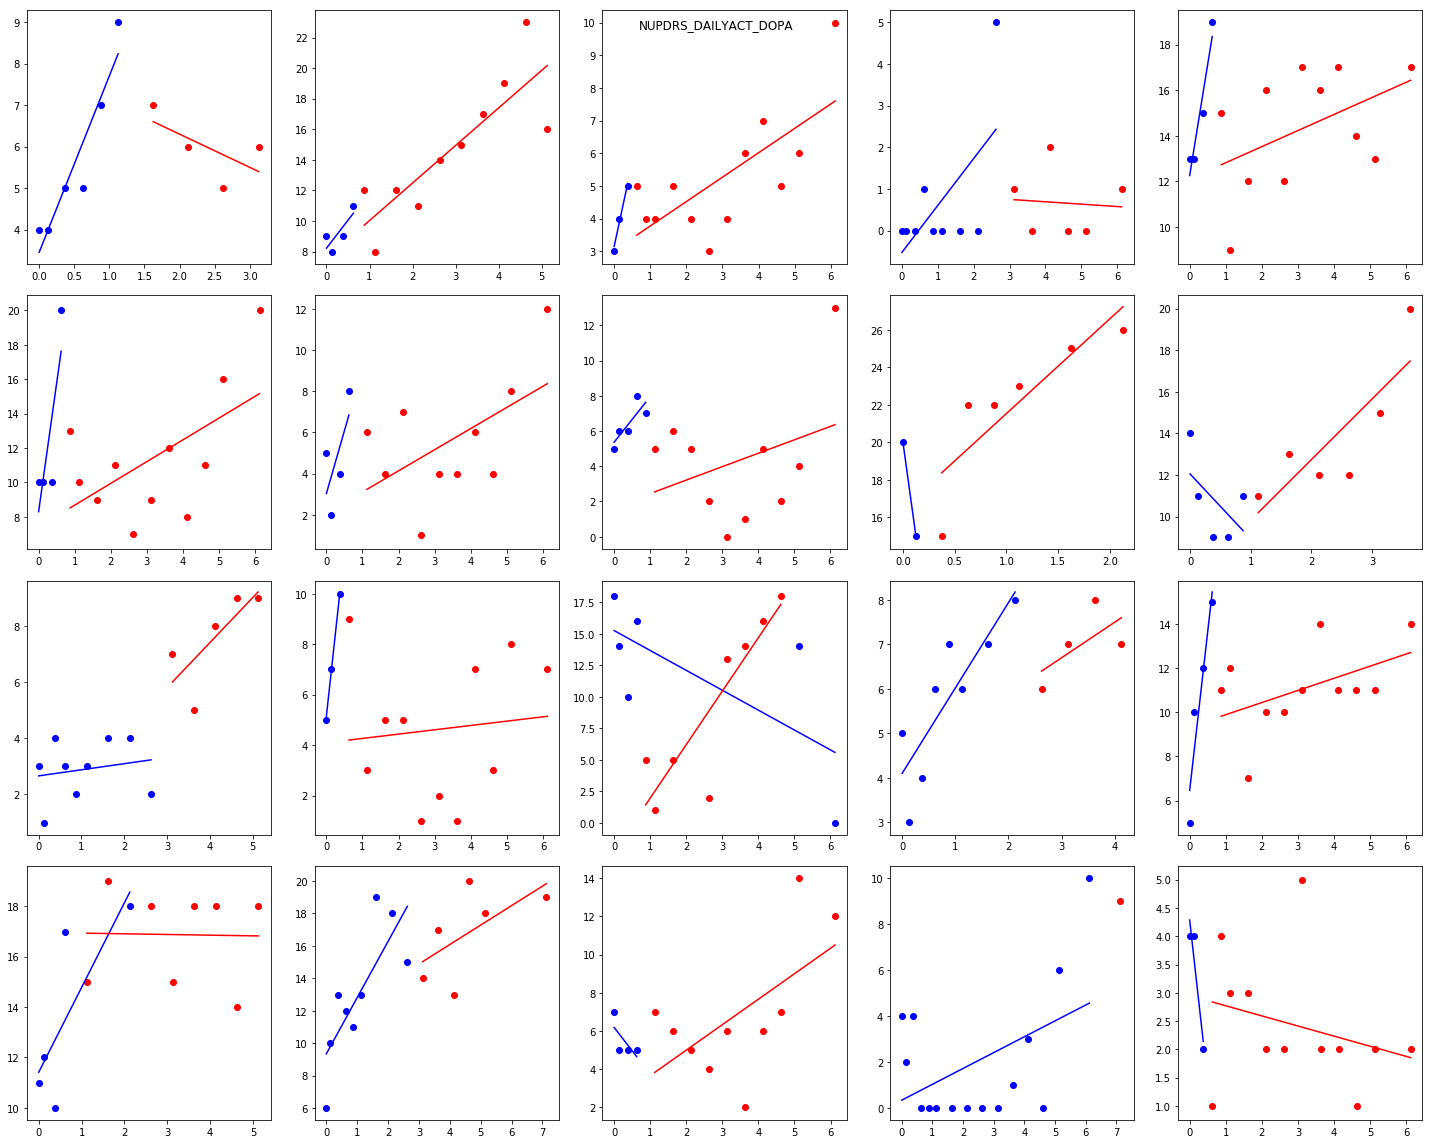

In [26]:
make_plots_2treatment_cond(pd_questions_df, 'NUPDRS_DAILYACT_DOPA', selected_patnos)

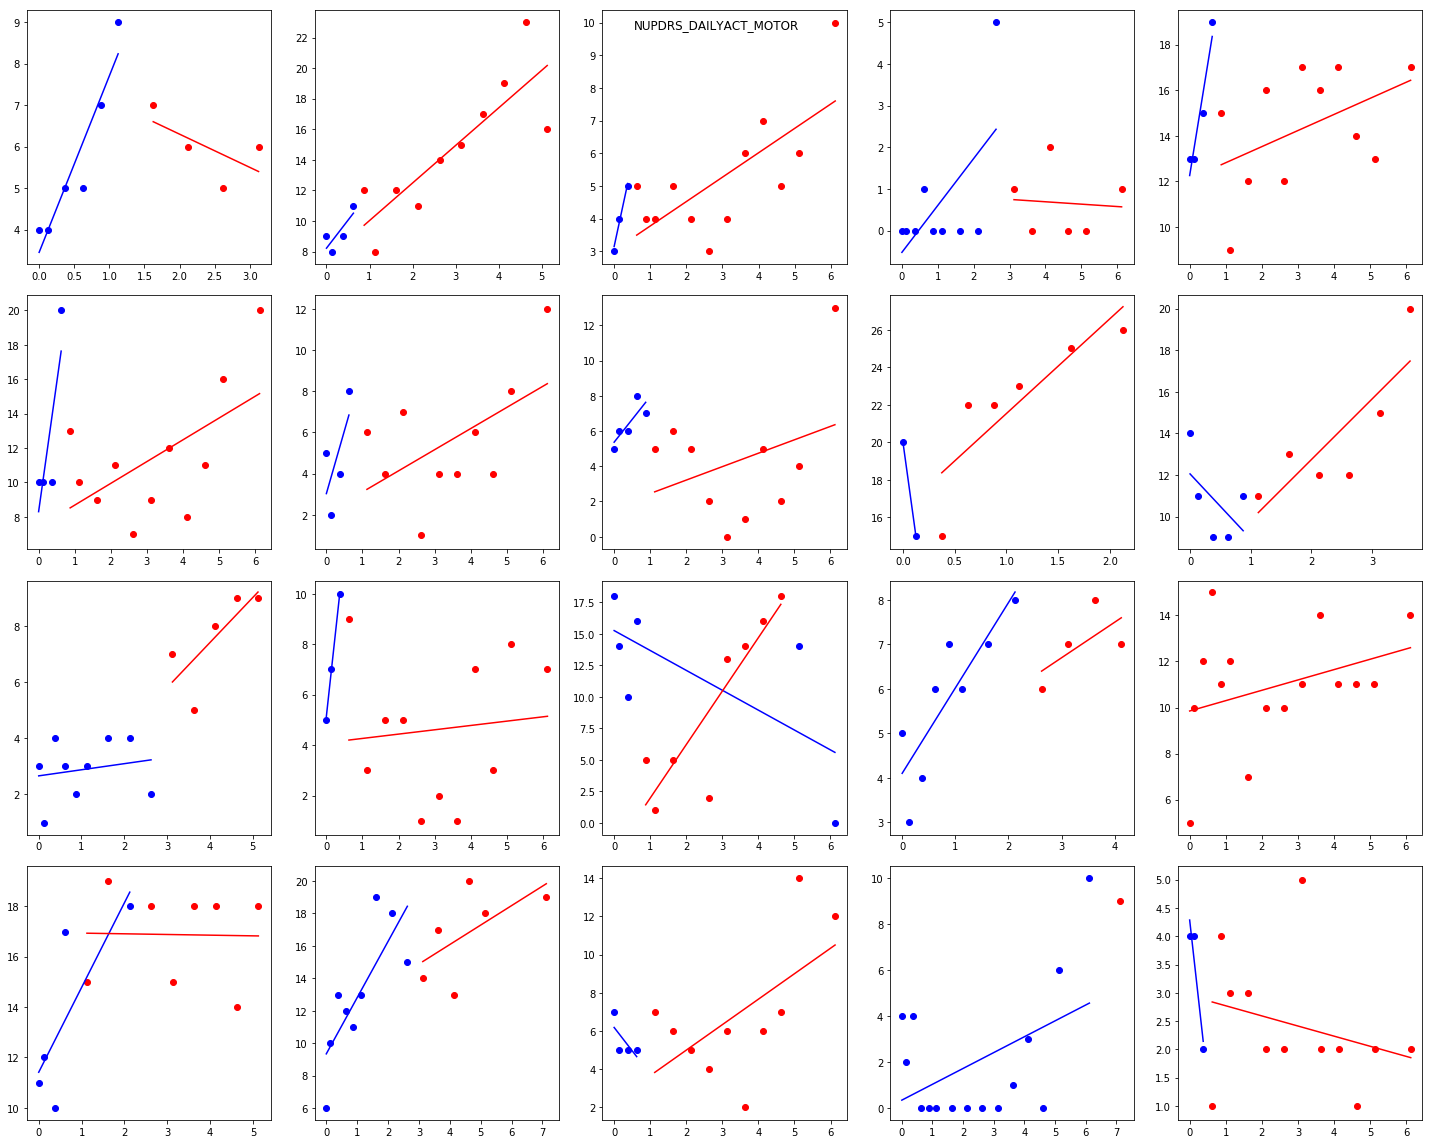

In [27]:
make_plots_2treatment_cond(pd_questions_df, 'NUPDRS_DAILYACT_MOTOR', selected_patnos)
# fine to just go with dopa replacement above - ignore this one for now

In [28]:
def get_4cond_avgs(df, subtotal_col_headers, num_cols_per_subtotal):
    assert len(subtotal_col_headers) == len(num_cols_per_subtotal)
    untreated_avg_cols = []
    off_avg_cols = []
    on_avg_cols = []
    maob_avg_cols = []
    for col_idx in range(len(subtotal_col_headers)):
        col = subtotal_col_headers[col_idx]
        num_cols = num_cols_per_subtotal[col_idx]
        df[col+'_avg_untreated'] = df[col+'_untreated']/float(num_cols)
        df[col+'_avg_off'] = df[col+'_off']/float(num_cols)
        df[col+'_avg_on'] = df[col+'_on']/float(num_cols)
        df[col+'_avg_maob'] = df[col+'_maob']/float(num_cols)
        untreated_avg_cols.append(col+'_avg_untreated')
        off_avg_cols.append(col+'_avg_off')
        on_avg_cols.append(col+'_avg_on')
        maob_avg_cols.append(col+'_avg_maob')
    first_col = subtotal_col_headers[0]
    df['NUPDRS3_avgsum_untreated'] = np.where(pd.isnull(df[first_col+'_untreated']), float('NaN'), \
                                              df[untreated_avg_cols].sum(axis=1))
    df['NUPDRS3_avgsum_off'] = np.where(pd.isnull(df[first_col+'_off']), float('NaN'), \
                                        df[off_avg_cols].sum(axis=1))
    df['NUPDRS3_avgsum_on'] = np.where(pd.isnull(df[first_col+'_on']), float('NaN'), \
                                       df[on_avg_cols].sum(axis=1))
    df['NUPDRS3_avgsum_maob'] = np.where(pd.isnull(df[first_col+'_maob']), float('NaN'), \
                                         df[maob_avg_cols].sum(axis=1))
    return df

In [29]:
# part 3 average of averages
subtotal_col_headers = ['NUPDRS_TREMOR', 'NUPDRS_RIGIDITY_LEFT', 'NUPDRS_RIGIDITY_RIGHT', 'NUPDRS_FACE', 'NUPDRS_GAIT']
num_cols_per_subtotal = [len(tremor_cols), len(rigidity_left_cols), len(rigidity_right_cols), len(face_cols), \
                         len(gait_cols)]
pd_questions_df = get_4cond_avgs(pd_questions_df, subtotal_col_headers, num_cols_per_subtotal)

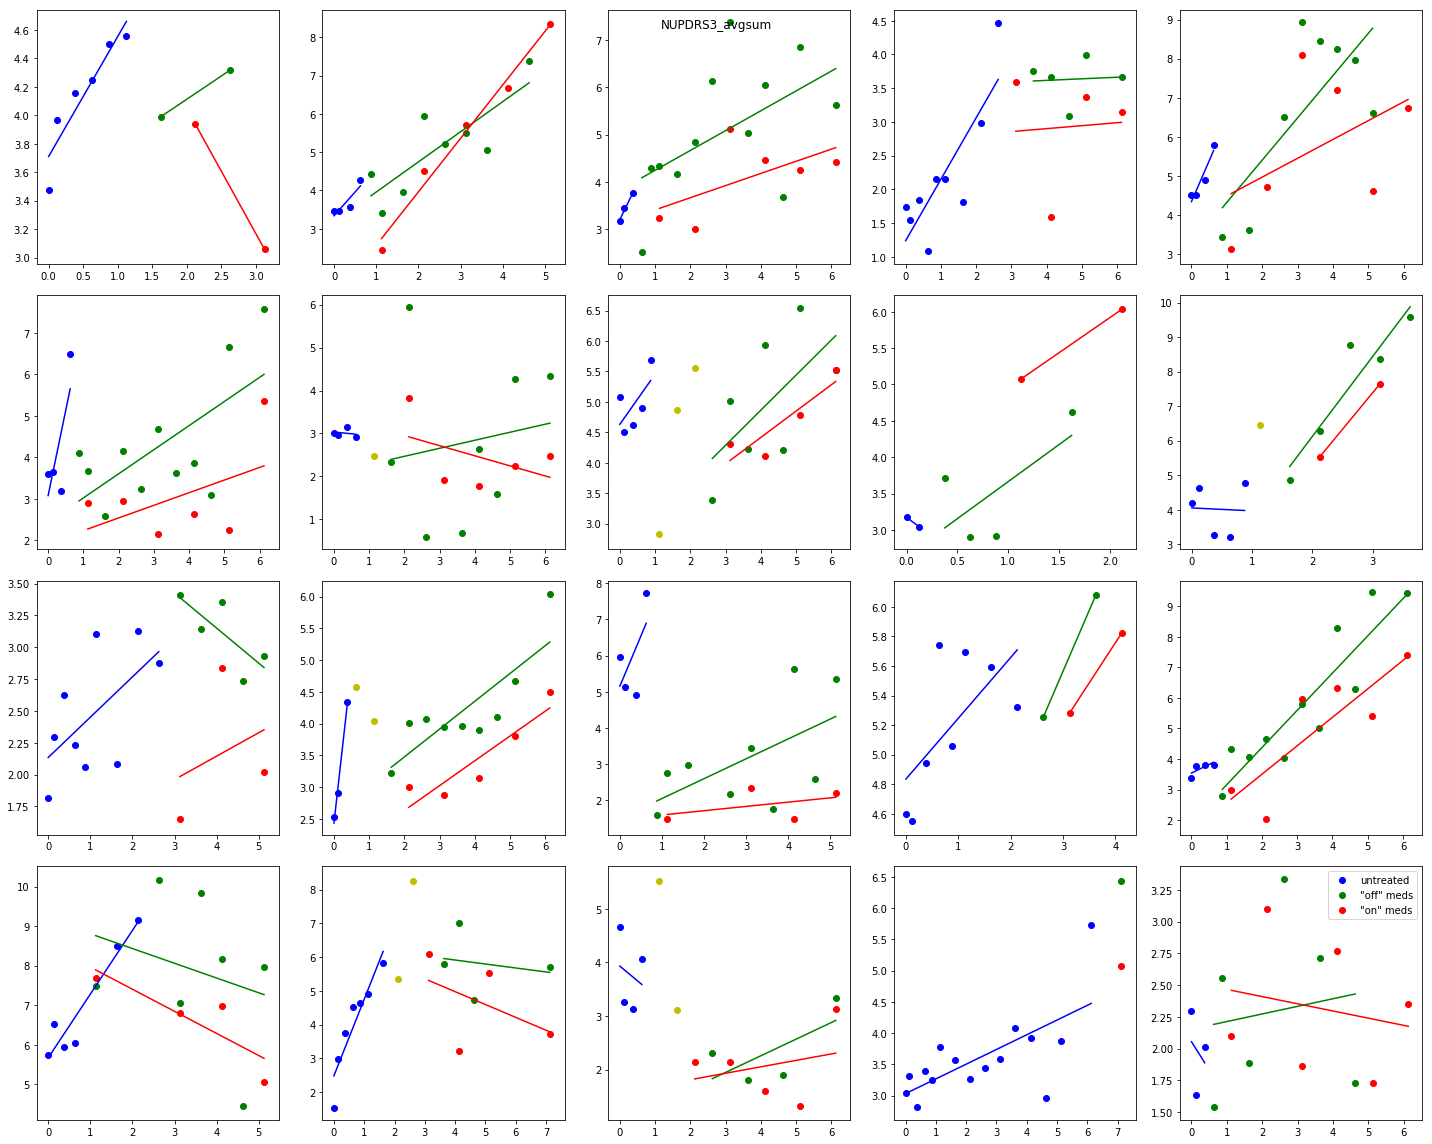

In [30]:
make_plots_4treatment_cond(pd_questions_df, 'NUPDRS3_avgsum', selected_patnos)

### Make plots so all features show up in a row for the same patient

In [17]:
pd_questions_df = pd_questions_df.merge(pd_total_df[['PATNO','EVENT_ID','NUPDRS3_untreated','NUPDRS3_on',\
                                                     'NUPDRS3_off','NUPDRS3_maob']], \
                                       on=['PATNO','EVENT_ID'], how='left', validate='one_to_one')

In [37]:
nupdrs_col_headers = ['NUPDRS_TREMOR', 'NUPDRS_RIGIDITY_LEFT', 'NUPDRS_RIGIDITY_RIGHT', 'NUPDRS_FACE', 'NUPDRS_GAIT', \
                      'NUPDRS_DAILYACT_DOPA', 'NUPDRS3']
# 'NUPDRS3_avgsum'
nupdrs_col_labels = ['Tremor', 'Rigidity left', 'Rigidity right', 'Face', 'Gait', 'Part II', 'Part III']
nupdrs_col_maxs = [15, 20, 20, 12, 12, 27, 60]
nupdrs_col_mins = [0, 0, 0, 0, 0, 0, 0]
#'Part III avg sum'
plt.rcParams.update({'font.size': 24})
def make_mdsupdrs_plot(df, offset=0):
    num_rows = 5
    num_cols = len(nupdrs_col_headers)
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))
    #, sharex=True, sharey=True)
    for row_idx in range(num_rows):
        patno = selected_patnos[row_idx+offset]
        patno_df = df.loc[df['PATNO']==patno]
         
        for col_idx in range(len(nupdrs_col_headers)):
            col_header = nupdrs_col_headers[col_idx]
            if col_header != 'NUPDRS_DAILYACT_DOPA':
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_off',col_header+'_on',\
                                               col_header+'_maob'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
            else:
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_treated'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
       
            untreated_df = patno_col_df.dropna(subset=[col_header+'_untreated'])
            untreated_times = untreated_df.EVENT_ID_DUR.values
            untreated_values = untreated_df[col_header+'_untreated'].values
            if len(untreated_times) > 0:
                ax[row_idx, col_idx].scatter(untreated_times, untreated_values, c='b', label='untreated')
                if len(untreated_times) > 1:
                    untreated_linreg = LinearRegression().fit(untreated_times.reshape(-1,1), untreated_values)
                    ax[row_idx, col_idx].plot(untreated_times, \
                                              untreated_linreg.predict(untreated_times.reshape(-1, 1)), 'b', \
                                              linewidth=4)
            ax[row_idx, col_idx].set_title(nupdrs_col_labels[col_idx])
            ax[row_idx, col_idx].set_ylim([nupdrs_col_mins[col_idx], nupdrs_col_maxs[col_idx]])
            if col_header != 'NUPDRS_DAILYACT_DOPA':
                off_df = patno_col_df.dropna(subset=[col_header+'_off'])
                off_times = off_df.EVENT_ID_DUR.values
                off_values = off_df[col_header+'_off'].values
                if len(off_times) > 0:
                    ax[row_idx, col_idx].scatter(off_times, off_values, c='g', label='"off" meds')
                    if len(off_times) > 1:
                        off_linreg = LinearRegression().fit(off_times.reshape(-1,1), off_values)
                        ax[row_idx, col_idx].plot(off_times, off_linreg.predict(off_times.reshape(-1, 1)), 'g', \
                                                  linestyle='dashdot', linewidth=4)

                on_df = patno_col_df.dropna(subset=[col_header+'_on'])
                on_times = on_df.EVENT_ID_DUR.values
                on_values = on_df[col_header+'_on'].values
                if len(on_times) > 0:
                    ax[row_idx, col_idx].scatter(on_times, on_values, c='r', label='"on" meds')
                    if len(on_times) > 1:
                        on_linreg = LinearRegression().fit(on_times.reshape(-1,1), on_values)
                        ax[row_idx, col_idx].plot(on_times, on_linreg.predict(on_times.reshape(-1, 1)), 'r', \
                                                  linestyle='dotted', linewidth=4)

                maob_df = patno_col_df.dropna(subset=[col_header+'_maob'])
                maob_times = maob_df.EVENT_ID_DUR.values
                maob_values = maob_df[col_header+'_maob'].values
                if len(maob_times) > 0:
                    ax[row_idx, col_idx].scatter(maob_times, maob_values, c='y', label='MAO-B')
                    if len(maob_times) > 1:
                        maob_linreg = LinearRegression().fit(maob_times.reshape(-1,1), maob_values)
                        ax[row_idx, col_idx].plot(maob_times, maob_linreg.predict(maob_times.reshape(-1, 1)), 'y', \
                                                  linestyle='dashed', linewidth=4)
            else:
                treated_df = patno_col_df.dropna(subset=[col_header+'_treated'])
                treated_times = treated_df.EVENT_ID_DUR.values
                treated_values = treated_df[col_header+'_treated'].values
                if len(treated_times) > 0:
                    ax[row_idx, col_idx].scatter(treated_times, treated_values, c='r', label='treated')
                    if len(treated_times) > 1:
                        treated_linreg = LinearRegression().fit(treated_times.reshape(-1,1), treated_values)
                        ax[row_idx, col_idx].plot(treated_times, \
                                                  treated_linreg.predict(treated_times.reshape(-1, 1)), 'r', \
                                                  linestyle='dotted', linewidth=4)
    plt.tight_layout()
    plt.legend()
    plt.savefig('nupdrs_subtotals_linear_offset' + str(offset) + '_asof_2019Jul31.pdf')
    plt.show()

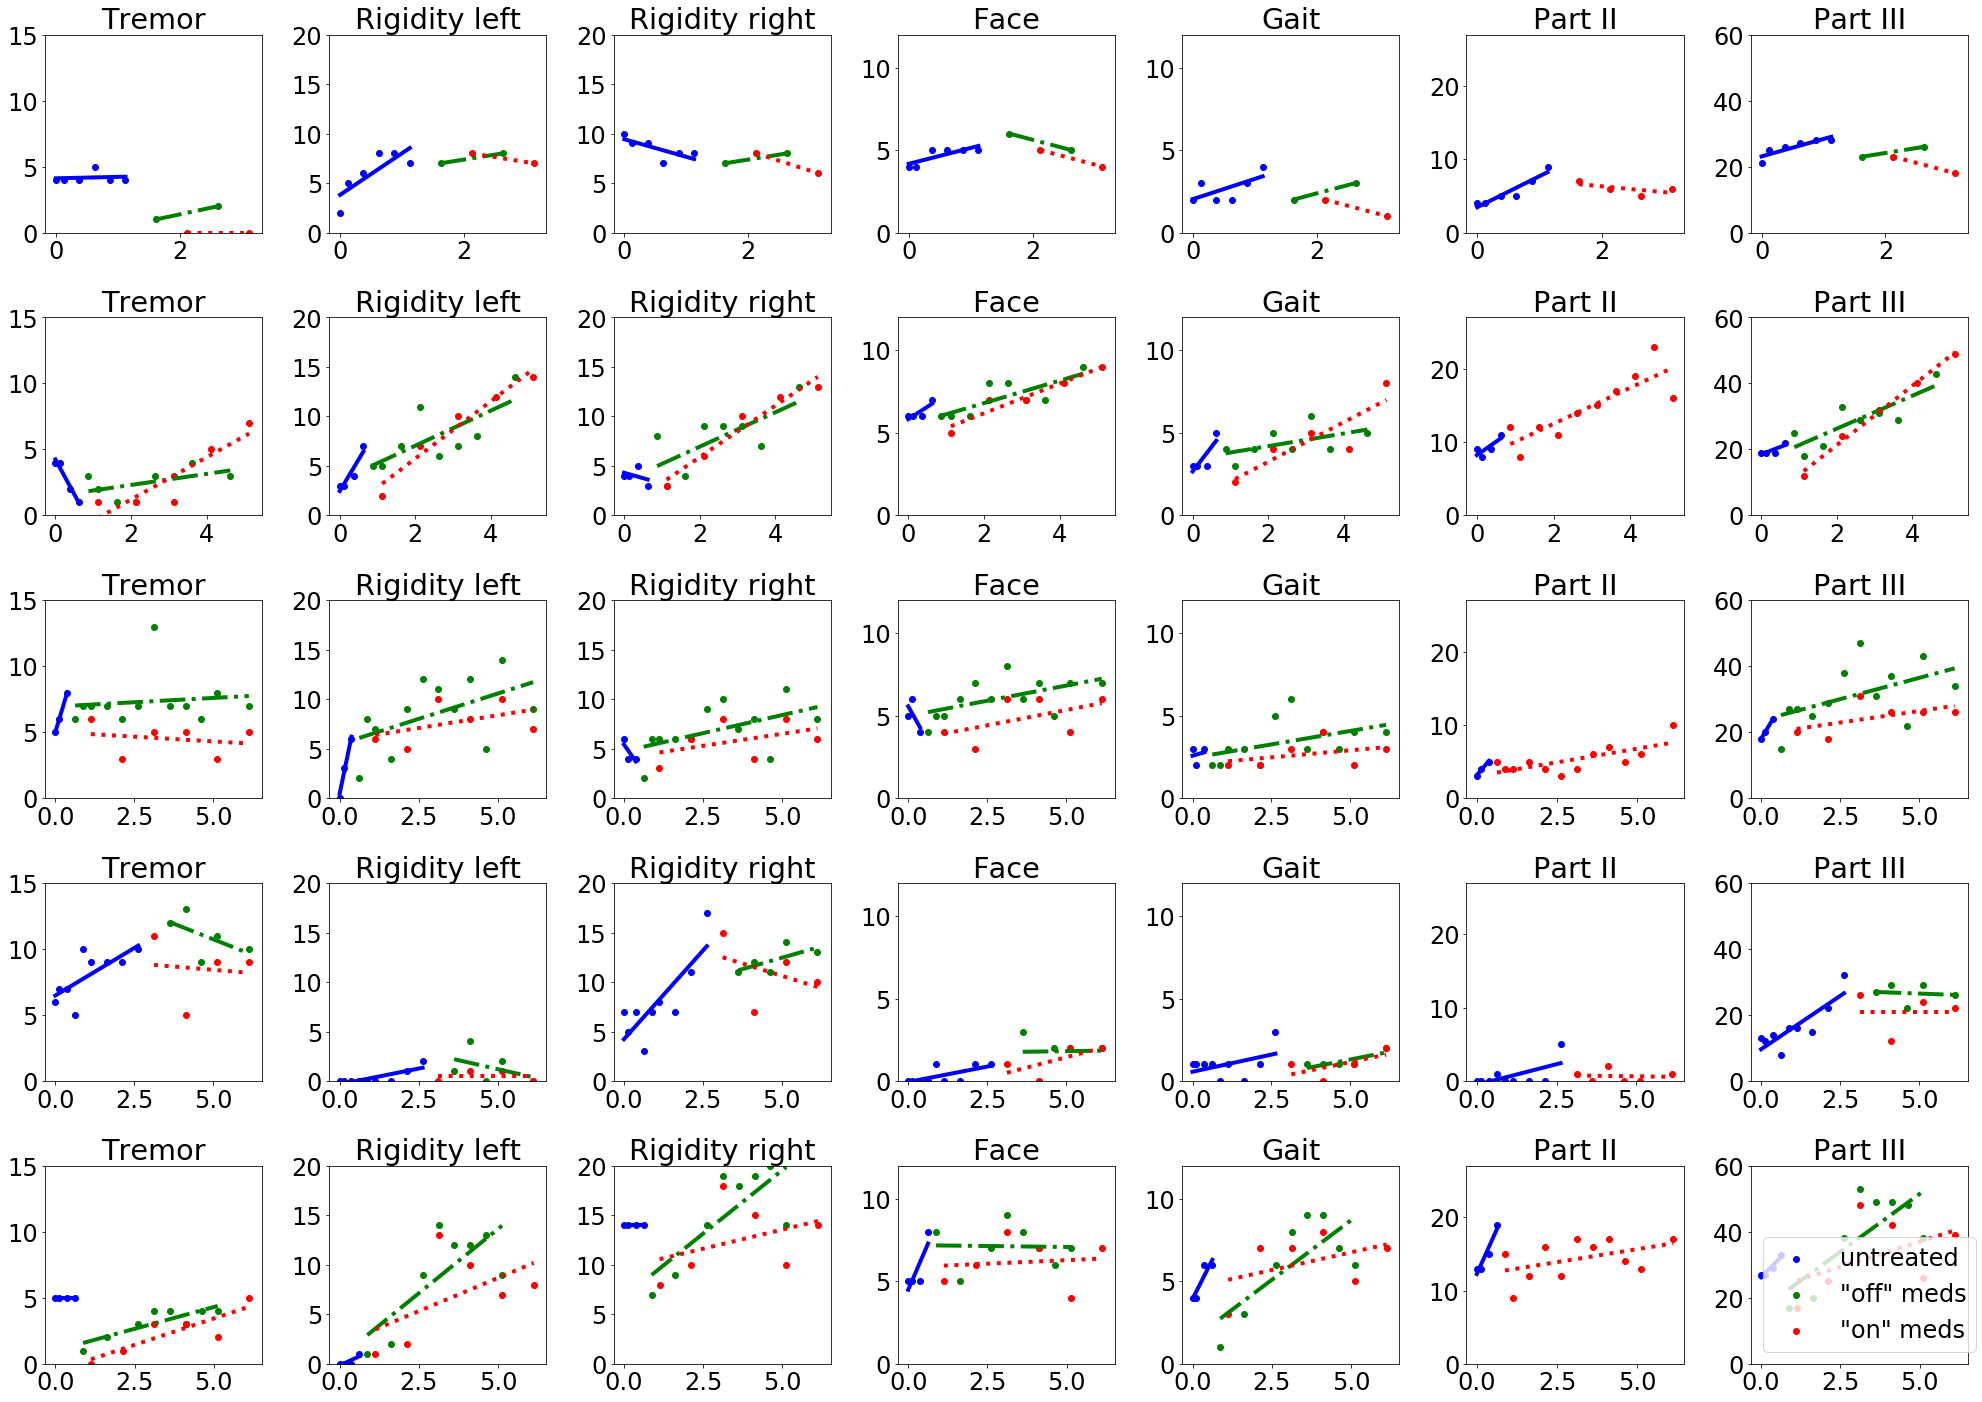

In [38]:
make_mdsupdrs_plot(pd_questions_df)

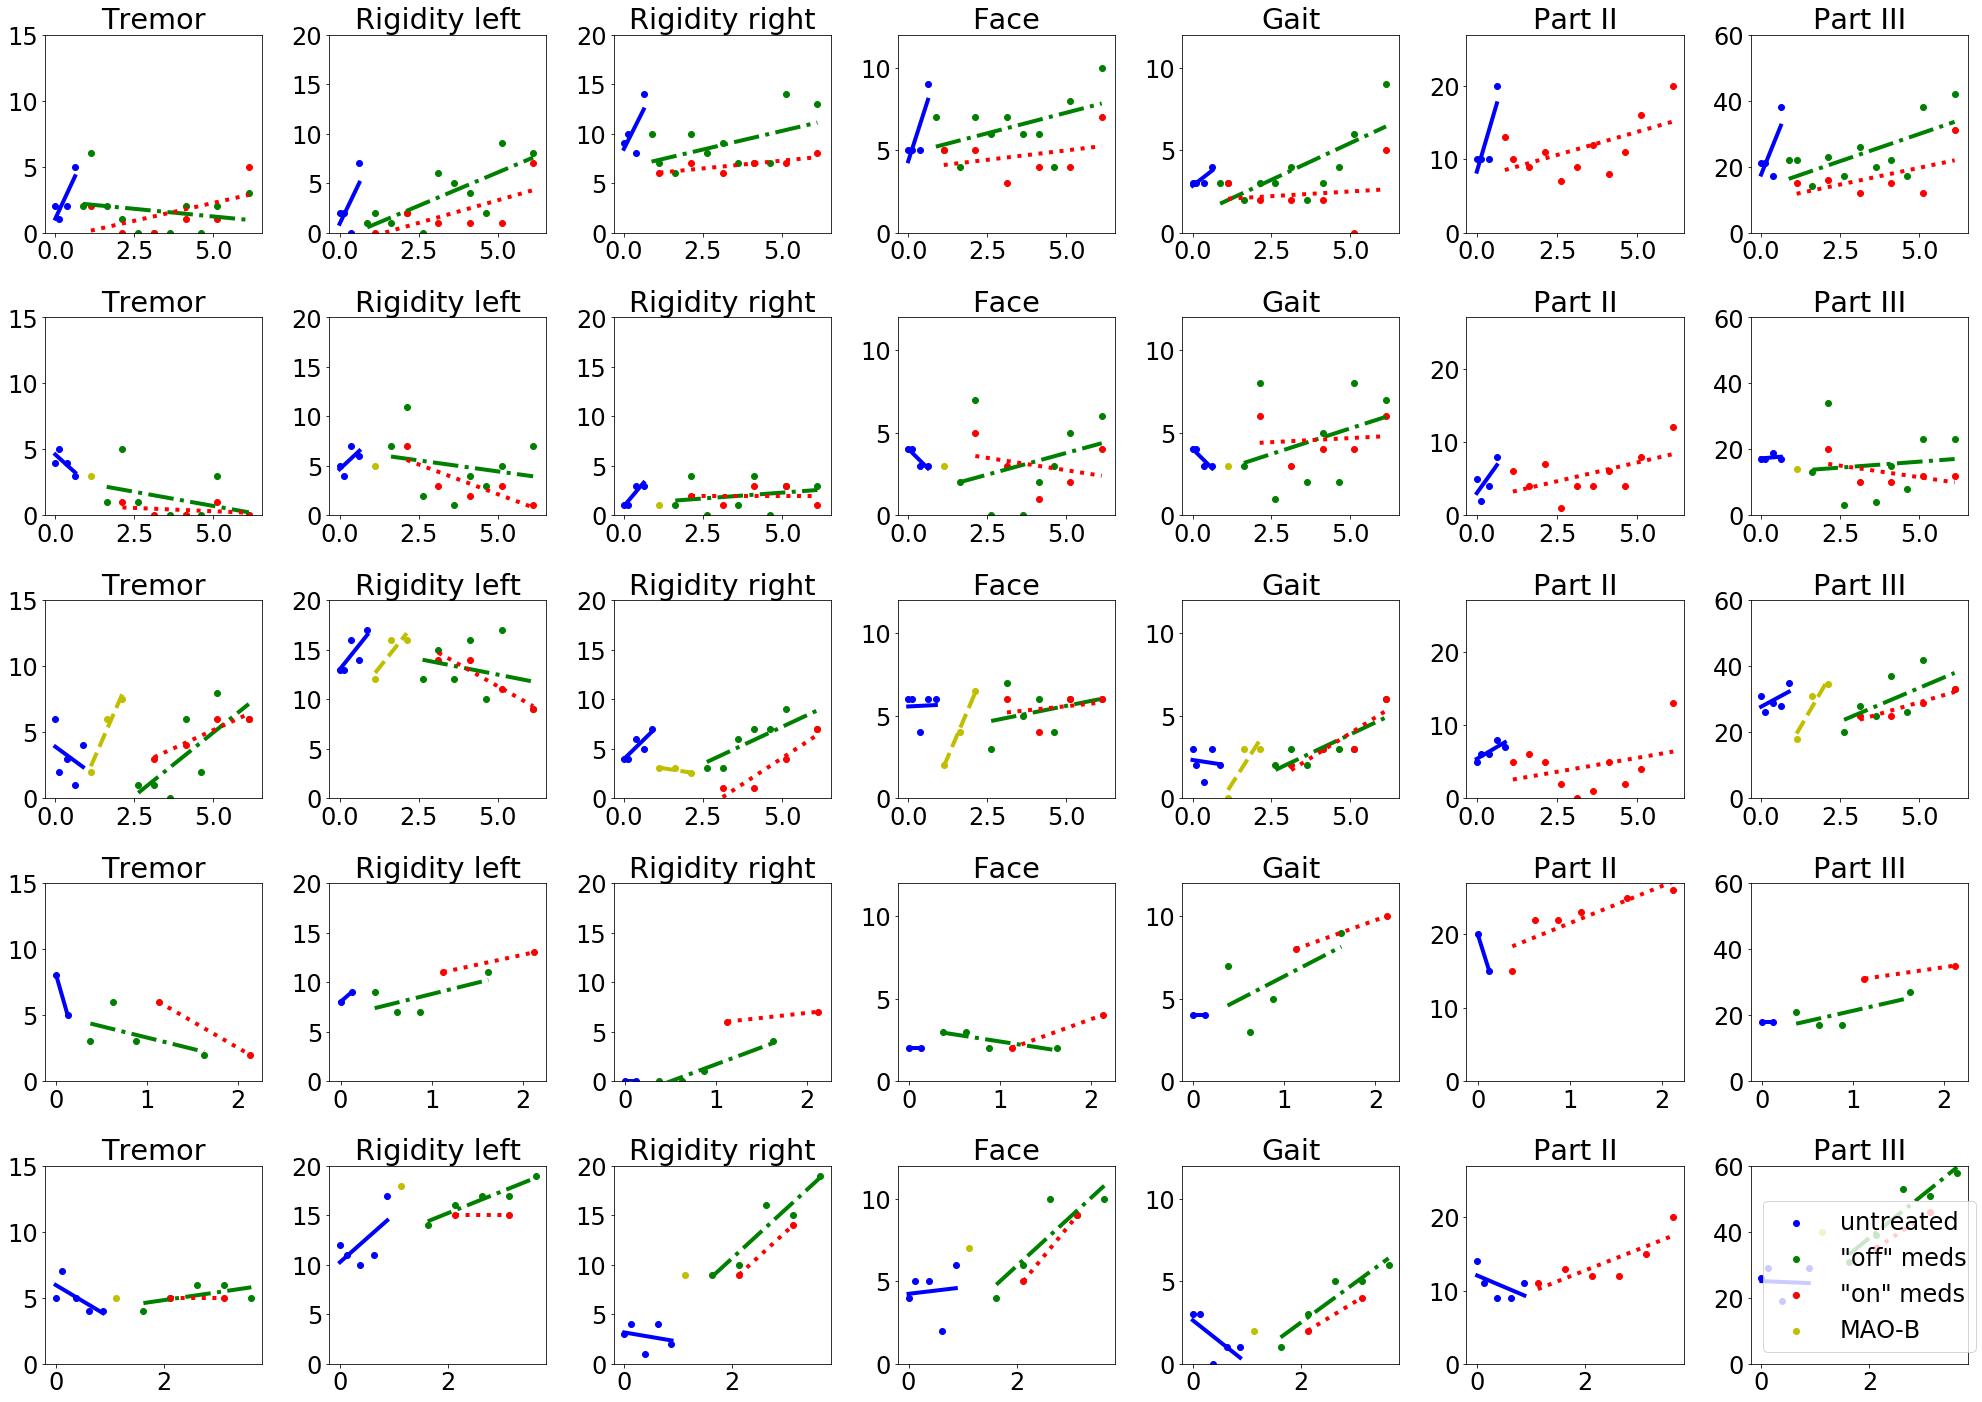

In [39]:
make_mdsupdrs_plot(pd_questions_df, offset=5)

### Plot tremor vs left rigidity untreated slopes

In [22]:
plt.rcParams.update({'font.size': 18})
from scipy.stats import pearsonr
untreated_slopes = np.empty((len(nupdrs_col_headers), pd_questions_df.PATNO.nunique()))
on_slopes = np.empty((len(nupdrs_col_headers), pd_questions_df.PATNO.nunique()))
off_slopes = np.empty((len(nupdrs_col_headers), pd_questions_df.PATNO.nunique()))
maob_slopes = np.empty((len(nupdrs_col_headers), pd_questions_df.PATNO.nunique()))
untreated_slopes_mask = np.zeros(untreated_slopes.shape) # 0 if slope not calculated, 1 if calculated
on_slopes_mask = np.zeros(on_slopes.shape)
off_slopes_mask = np.zeros(off_slopes.shape)
maob_slopes_mask = np.zeros(maob_slopes.shape)
patnos = pd_questions_df.PATNO.unique()
for patno_idx in range(len(patnos)):
    patno_df = pd_questions_df.loc[pd_questions_df['PATNO']==patnos[patno_idx]]
    for col_idx in range(len(nupdrs_col_headers)):
        col = nupdrs_col_headers[col_idx]
        untreated_col_df = patno_df[['EVENT_ID_DUR', col + '_untreated']].dropna()
        if len(untreated_col_df) >= 2:
            untreated_times = untreated_col_df.EVENT_ID_DUR.values
            untreated_feat_vals = untreated_col_df[col + '_untreated'].values
            untreated_linreg = LinearRegression().fit(untreated_times.reshape(-1,1), untreated_feat_vals)
            untreated_slopes[col_idx, patno_idx] = untreated_linreg.coef_[0]
            untreated_slopes_mask[col_idx, patno_idx] = 1
        if col == 'NUPDRS_DAILYACT_DOPA':
            treated_col_df = patno_df[['EVENT_ID_DUR', col + '_treated']].dropna()
            if len(treated_col_df) >= 2:
                treated_times = treated_col_df.EVENT_ID_DUR.values
                treated_feat_vals = treated_col_df[col + '_treated'].values
                treated_linreg = LinearRegression().fit(treated_times.reshape(-1,1), treated_feat_vals)
                on_slopes[col_idx, patno_idx] = treated_linreg.coef_[0]
                off_slopes[col_idx, patno_idx] = treated_linreg.coef_[0]
                maob_slopes[col_idx, patno_idx] = treated_linreg.coef_[0]
                on_slopes_mask[col_idx, patno_idx] = 1
                off_slopes_mask[col_idx, patno_idx] = 1
                maob_slopes_mask[col_idx, patno_idx] = 1
        else:
            on_col_df = patno_df[['EVENT_ID_DUR', col + '_on']].dropna()
            if len(on_col_df) >= 2:
                on_times = on_col_df.EVENT_ID_DUR.values
                on_feat_vals = on_col_df[col + '_on'].values
                on_linreg = LinearRegression().fit(on_times.reshape(-1,1), on_feat_vals)
                on_slopes[col_idx, patno_idx] = on_linreg.coef_[0]
                on_slopes_mask[col_idx, patno_idx] = 1
            off_col_df = patno_df[['EVENT_ID_DUR', col + '_off']].dropna()
            if len(off_col_df) >= 2:
                off_times = off_col_df.EVENT_ID_DUR.values
                off_feat_vals = off_col_df[col + '_off'].values
                off_linreg = LinearRegression().fit(off_times.reshape(-1,1), off_feat_vals)
                off_slopes[col_idx, patno_idx] = off_linreg.coef_[0]
                off_slopes_mask[col_idx, patno_idx] = 1
            maob_col_df = patno_df[['EVENT_ID_DUR', col + '_maob']].dropna()
            if len(maob_col_df) >= 2:
                maob_times = maob_col_df.EVENT_ID_DUR.values
                maob_feat_vals = maob_col_df[col + '_maob'].values
                maob_linreg = LinearRegression().fit(maob_times.reshape(-1,1), maob_feat_vals)
                maob_slopes[col_idx, patno_idx] = maob_linreg.coef_[0]
                maob_slopes_mask[col_idx, patno_idx] = 1

In [36]:
print(untreated_slopes_mask.sum(axis=1))
print(on_slopes_mask.sum(axis=1))
print(off_slopes_mask.sum(axis=1))
print(maob_slopes_mask.sum(axis=1))

[423. 423. 423. 423. 423. 423. 423.]
[340. 340. 340. 340. 340. 385. 340.]
[360. 360. 360. 360. 360. 385. 360.]
[105. 105. 105. 105. 105. 385. 105.]


In [26]:
untreated_slope_corrs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
on_slope_corrs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
off_slope_corrs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
maob_slope_corrs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
from scipy.stats import pearsonr
for i in range(len(nupdrs_col_headers)-1):
    for j in range(i+1,len(nupdrs_col_headers)):
        untreated_slope_pairs = untreated_slopes[[i,j]]
        untreated_slope_pairs = untreated_slope_pairs[:, np.nonzero(np.where(untreated_slopes_mask[i] \
                                                                        + untreated_slopes_mask[j] == 2, 1, 0))[0]]
        corr, _ = pearsonr(untreated_slope_pairs[0], untreated_slope_pairs[1])
        untreated_slope_corrs[i,j] = corr
        untreated_slope_corrs[j,i] = corr
        
        on_slope_pairs = on_slopes[[i,j]]
        on_slope_pairs = on_slope_pairs[:, np.nonzero(np.where(on_slopes_mask[i] + on_slopes_mask[j] == 2, 1, 0))[0]]
        corr, _ = pearsonr(on_slope_pairs[0], on_slope_pairs[1])
        on_slope_corrs[i,j] = corr
        on_slope_corrs[j,i] = corr
        
        off_slope_pairs = off_slopes[[i,j]]
        off_slope_pairs = off_slope_pairs[:, np.nonzero(np.where(off_slopes_mask[i] \
                                                                 + off_slopes_mask[j] == 2, 1, 0))[0]]
        corr, _ = pearsonr(off_slope_pairs[0], off_slope_pairs[1])
        off_slope_corrs[i,j] = corr
        off_slope_corrs[j,i] = corr
        
        maob_slope_pairs = maob_slopes[[i,j]]
        maob_slope_pairs = maob_slope_pairs[:, np.nonzero(np.where(maob_slopes_mask[i] \
                                                                   + maob_slopes_mask[j] == 2, 1, 0))[0]]
        corr, _ = pearsonr(maob_slope_pairs[0], maob_slope_pairs[1])
        maob_slope_corrs[i,j] = corr
        maob_slope_corrs[j,i] = corr

In [40]:
untreated_corr_df = pd.DataFrame(untreated_slope_corrs, columns=nupdrs_col_headers)
untreated_corr_df[''] = nupdrs_col_headers
untreated_corr_df = untreated_corr_df.set_index('')

In [41]:
on_corr_df = pd.DataFrame(on_slope_corrs, columns=nupdrs_col_headers)
on_corr_df[''] = nupdrs_col_headers
on_corr_df = on_corr_df.set_index('')

In [42]:
off_corr_df = pd.DataFrame(off_slope_corrs, columns=nupdrs_col_headers)
off_corr_df[''] = nupdrs_col_headers
off_corr_df = off_corr_df.set_index('')

In [43]:
maob_corr_df = pd.DataFrame(maob_slope_corrs, columns=nupdrs_col_headers)
maob_corr_df[''] = nupdrs_col_headers
maob_corr_df = maob_corr_df.set_index('')

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


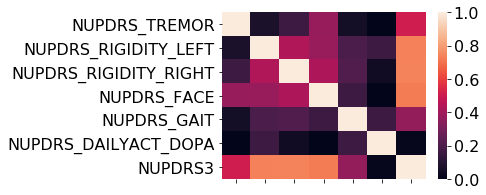

In [71]:
import seaborn as sns
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7,3))
sns.heatmap(untreated_corr_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelbottom=False)
fig.tight_layout()
fig.savefig('untreated_slope_corr.pdf')
fig.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


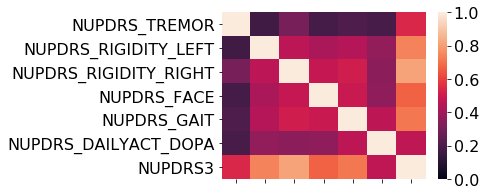

In [70]:
fig, ax = plt.subplots(figsize=(7,3))
sns.heatmap(on_corr_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelbottom=False)
fig.tight_layout()
fig.savefig('on_slope_corr.pdf')
fig.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


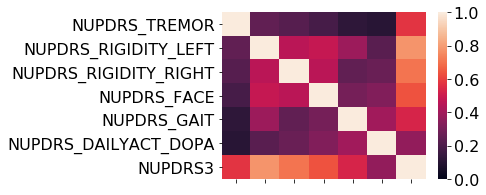

In [69]:
fig, ax = plt.subplots(figsize=(7,3))
sns.heatmap(off_corr_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelbottom=False)
fig.tight_layout()
fig.savefig('off_slope_corr.pdf')
fig.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


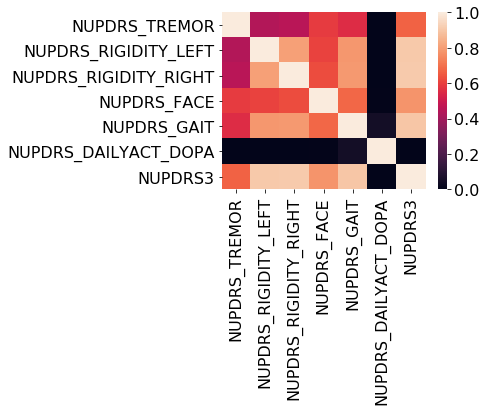

In [68]:
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(maob_corr_df, vmin=0, vmax=1, ax=ax)
#ax.tick_params(labelbottom=False)
fig.tight_layout()
fig.savefig('maob_slope_corr.pdf')
fig.show()

In [55]:
untreated_signs_agree_freqs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
on_signs_agree_freqs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
off_signs_agree_freqs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
maob_signs_agree_freqs = np.ones((len(nupdrs_col_headers), len(nupdrs_col_headers)))
for i in range(len(nupdrs_col_headers)-1):
    for j in range(i+1,len(nupdrs_col_headers)):
        untreated_slope_pairs = untreated_slopes[[i,j]]
        untreated_slope_pairs = untreated_slope_pairs[:, np.nonzero(np.where(untreated_slopes_mask[i] \
                                                                        + untreated_slopes_mask[j] == 2, 1, 0))[0]]
        untreated_slope_sign_agreement = np.multiply(untreated_slope_pairs[0], untreated_slope_pairs[1])
        untreated_agree_freq \
            = np.sum(np.where(untreated_slope_sign_agreement >= 0, 1, 0))/float(untreated_slope_pairs.shape[1])
        untreated_signs_agree_freqs[i,j] = untreated_agree_freq
        untreated_signs_agree_freqs[j, i] = untreated_agree_freq
        
        on_slope_pairs = on_slopes[[i,j]]
        on_slope_pairs = on_slope_pairs[:, np.nonzero(np.where(on_slopes_mask[i] + on_slopes_mask[j] == 2, 1, 0))[0]]
        on_slope_sign_agreement = np.multiply(on_slope_pairs[0], on_slope_pairs[1])
        on_agree_freq = np.sum(np.where(on_slope_sign_agreement >= 0, 1, 0))/float(on_slope_pairs.shape[1])
        on_signs_agree_freqs[i,j] = on_agree_freq
        on_signs_agree_freqs[j, i] = on_agree_freq
        
        off_slope_pairs = off_slopes[[i,j]]
        off_slope_pairs = off_slope_pairs[:, np.nonzero(np.where(off_slopes_mask[i] \
                                                                 + off_slopes_mask[j] == 2, 1, 0))[0]]
        off_slope_sign_agreement = np.multiply(off_slope_pairs[0], off_slope_pairs[1])
        off_agree_freq = np.sum(np.where(off_slope_sign_agreement >= 0, 1, 0))/float(off_slope_pairs.shape[1])
        off_signs_agree_freqs[i,j] = off_agree_freq
        off_signs_agree_freqs[j, i] = off_agree_freq
        
        maob_slope_pairs = maob_slopes[[i,j]]
        maob_slope_pairs = maob_slope_pairs[:, np.nonzero(np.where(maob_slopes_mask[i] \
                                                                   + maob_slopes_mask[j] == 2, 1, 0))[0]]
        maob_slope_sign_agreement = np.multiply(maob_slope_pairs[0], maob_slope_pairs[1])
        maob_agree_freq = np.sum(np.where(maob_slope_sign_agreement >= 0, 1, 0))/float(maob_slope_pairs.shape[1])
        maob_signs_agree_freqs[i,j] = maob_agree_freq
        maob_signs_agree_freqs[j, i] = maob_agree_freq

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


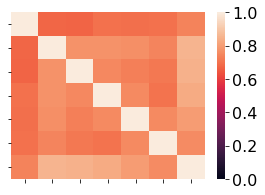

In [72]:
untreated_signs_df = pd.DataFrame(untreated_signs_agree_freqs, columns=nupdrs_col_headers)
untreated_signs_df[''] = nupdrs_col_headers
untreated_signs_df = untreated_signs_df.set_index('')
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(untreated_signs_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)
fig.tight_layout()
fig.savefig('untreated_slope_signs.pdf')
fig.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


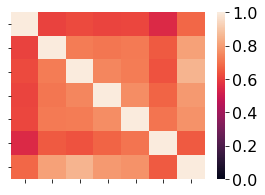

In [73]:
on_signs_df = pd.DataFrame(on_signs_agree_freqs, columns=nupdrs_col_headers)
on_signs_df[''] = nupdrs_col_headers
on_signs_df = on_signs_df.set_index('')
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(on_signs_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)
fig.tight_layout()
fig.savefig('on_slope_signs.pdf')
fig.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


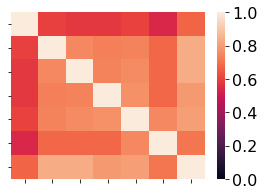

In [74]:
off_signs_df = pd.DataFrame(off_signs_agree_freqs, columns=nupdrs_col_headers)
off_signs_df[''] = nupdrs_col_headers
off_signs_df = off_signs_df.set_index('')
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(off_signs_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)
fig.tight_layout()
fig.savefig('off_slope_signs.pdf')
fig.show()

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


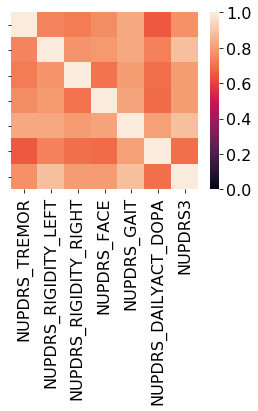

In [75]:
maob_signs_df = pd.DataFrame(maob_signs_agree_freqs, columns=nupdrs_col_headers)
maob_signs_df[''] = nupdrs_col_headers
maob_signs_df = maob_signs_df.set_index('')
fig, ax = plt.subplots(figsize=(4,6))
sns.heatmap(maob_signs_df, vmin=0, vmax=1, ax=ax)
ax.tick_params(labelleft=False)
fig.tight_layout()
fig.savefig('maob_slope_signs.pdf')
fig.show()

In [34]:
plt.rcParams.update({'font.size': 18})
from scipy.stats import pearsonr
def plot_untreated_slope_correlations(df, feat1, feat2, xlim=None, ylim=None):
    untreated_feat1_slopes = []
    untreated_feat2_slopes = []
    for patno in df.PATNO.unique():
        patno_df = df.loc[df['PATNO']==patno]
        untreated_df = patno_df.dropna(subset=[feat1+'_untreated',feat2+'_untreated'])
        if len(untreated_df) < 3:
            continue
        untreated_times = untreated_df.EVENT_ID_DUR.values
        untreated_feat1_values = untreated_df[feat1+'_untreated'].values
        untreated_feat2_values = untreated_df[feat2+'_untreated'].values
        untreated_feat1_linreg = LinearRegression().fit(untreated_times.reshape(-1,1), untreated_feat1_values)
        untreated_feat2_linreg = LinearRegression().fit(untreated_times.reshape(-1,1), untreated_feat2_values)
        untreated_feat1_slopes.append(untreated_feat1_linreg.coef_[0])
        untreated_feat2_slopes.append(untreated_feat2_linreg.coef_[0])
    plt.scatter(np.array(untreated_feat1_slopes), np.array(untreated_feat2_slopes))
    plt.xlabel(feat1 + ' slopes')
    plt.ylabel(feat2 + ' slopes')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()
    print(pearsonr(untreated_feat1_slopes, untreated_feat2_slopes))

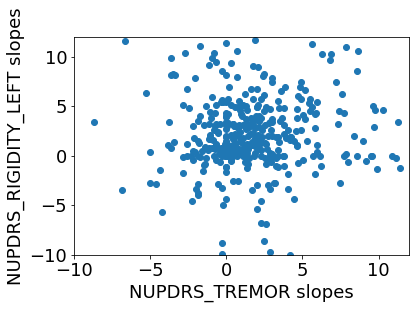

(0.09809861739517736, 0.04879218015894452)


In [35]:
plot_untreated_slope_correlations(pd_questions_df, 'NUPDRS_TREMOR', 'NUPDRS_RIGIDITY_LEFT', [-10,12], [-10,12])

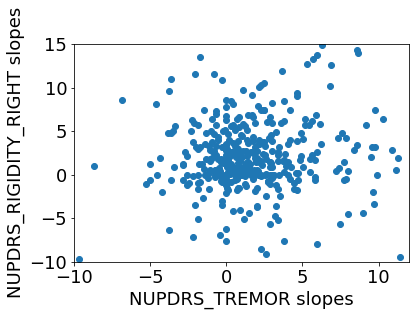

(0.10236555920573527, 0.03972931265739936)


In [36]:
plot_untreated_slope_correlations(pd_questions_df, 'NUPDRS_TREMOR', 'NUPDRS_RIGIDITY_RIGHT', [-10,12], [-10,15])

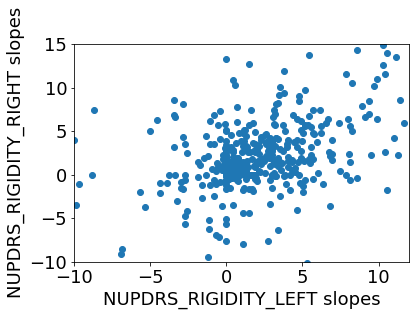

(0.44286527910231194, 7.787046356147022e-21)


In [37]:
plot_untreated_slope_correlations(pd_questions_df, 'NUPDRS_RIGIDITY_LEFT', 'NUPDRS_RIGIDITY_RIGHT', [-10,12], [-10,15])

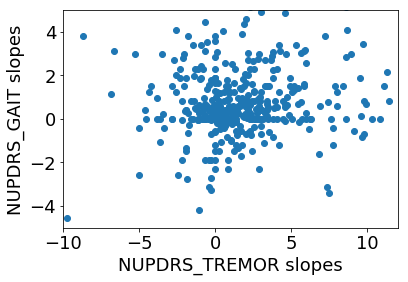

(0.15632969867246638, 0.0016223837874963975)


In [38]:
plot_untreated_slope_correlations(pd_questions_df, 'NUPDRS_TREMOR', 'NUPDRS_GAIT', [-10,12], [-5,5])

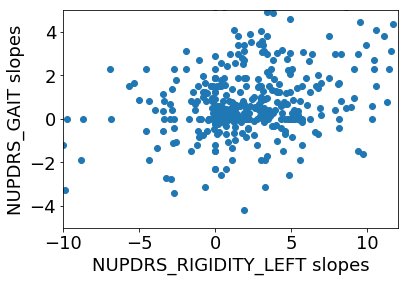

(0.3371803748826805, 3.375504113762701e-12)


In [39]:
plot_untreated_slope_correlations(pd_questions_df, 'NUPDRS_RIGIDITY_LEFT', 'NUPDRS_GAIT', [-10,12], [-5,5])

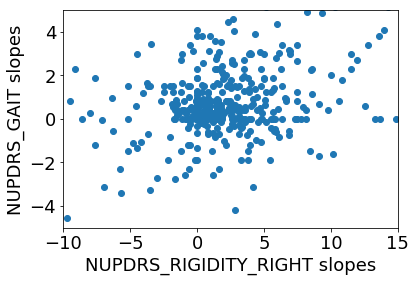

(0.35130967904993, 3.530149986027027e-13)


In [40]:
plot_untreated_slope_correlations(pd_questions_df, 'NUPDRS_RIGIDITY_RIGHT', 'NUPDRS_GAIT', [-10,15], [-5,5])

In [41]:
feats = np.array(['GAIT','RIGIDITY_LEFT','RIGIDITY_RIGHT','TREMOR'])
corrs = np.array([[1,0.338,0.351,0.158],[0.338,1,0.443,0.096],[0.351,0.443,1,0.102],[0.158,0.096,0.102,1]])
corr_df = pd.DataFrame(corrs, columns=feats.tolist())
corr_df['Feat'] = feats
corr_df = corr_df.set_index('Feat')
display(corr_df)

,GAIT,RIGIDITY_LEFT,RIGIDITY_RIGHT,TREMOR
Feat,,,,
GAIT,1.000,0.338,0.351,0.158
RIGIDITY_LEFT,0.338,1.000,0.443,0.096
RIGIDITY_RIGHT,0.351,0.443,1.000,0.102
TREMOR,0.158,0.096,0.102,1.000


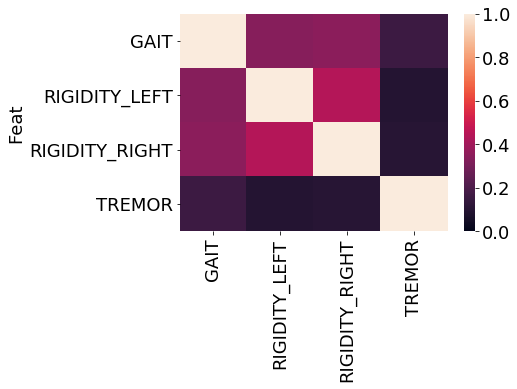

In [42]:
import seaborn as sns
sns.heatmap(corr_df, vmin=0, vmax=1)

### Make plots without linear regression

In [5]:
datadir = '../../../datasets/ppmi/visit_feature_inputs_asof_2019Jan24_using_CMEDTM/'
pd_questions_df = pd.read_csv(datadir + 'PD_questions_across_time.csv')
pd_totals_df = pd.read_csv(datadir + 'PD_totals_across_time.csv')

In [6]:
subtotal_maps = {'NUPDRS3_TREMOR': ['NP3RTALL', 'NP3RTALU', 'NP3KTRML', 'NP3PTRML', 'NP3KTRMR', 'NP3PTRMR', 'NP3RTARU', \
                                    'NP3RTALJ', 'NP3RTARL', 'NP2TRMR', 'NP3RTCON'], \
                 'NUPDRS3_RIGID_LEFT': ['NP3RIGLU', 'NP3RIGLL', 'NP3PRSPL', 'NP3FTAPL', 'NP3HMOVL', 'NP3LGAGL', \
                                        'NP3TTAPL'], \
                 'NUPDRS3_RIGID_RIGHT': ['NP3RIGRL', 'NP3RIGRU', 'NP3PRSPR', 'NP3FTAPR', 'NP3HMOVR', 'NP3LGAGR', \
                                         'NP3TTAPR'], \
                 'NUPDRS3_FACE': ['NP3SPCH', 'NP3RIGN', 'NP3BRADY', 'NP3FACXP'], \
                 'NUPDRS3_GAIT': ['NP3FRZGT', 'NP3PSTBL', 'NP3RISNG', 'NP3GAIT', 'NP3POSTR'], \
                 'NUPDRS2_DAILYACT': ['NP2HWRT', 'NP2FREZ', 'NP2HYGN', 'NP2EAT', 'NP2HOBB', 'NP2WALK', 'NP2DRES', \
                                      'NP2RISE', 'NP2TURN', 'NP2SWAL', 'NP2SALV', 'NP2SPCH']
                }
for col in pd_questions_df.columns:
    if col.startswith('NP2'):
        pd_questions_df[col + '_untreated'] = np.where(~pd.isnull(pd_questions_df['NP3RTALL_untreated']), \
                                                       pd_questions_df[col], float('NaN'))
        pd_questions_df[col + '_treated'] \
            = np.where(np.logical_or.reduce((~pd.isnull(pd_questions_df['NP3RTALL_on']), \
                                             ~pd.isnull(pd_questions_df['NP3RTALL_off']), \
                                             ~pd.isnull(pd_questions_df['NP3RTALL_maob']))), \
                       pd_questions_df[col], float('NaN'))
for subtotal in subtotal_maps.keys():
    untreated_components = [col + '_untreated' for col in subtotal_maps[subtotal]]
    pd_questions_df[subtotal+'_untreated'] \
        = np.where(np.logical_and.reduce([~pd.isnull(pd_questions_df[component]) \
                                          for component in untreated_components]), \
                   pd_questions_df[untreated_components].sum(axis=1), float('NaN'))
    if subtotal == 'NUPDRS2_DAILYACT':
        treated_components = [col + '_treated' for col in subtotal_maps[subtotal]]
        pd_questions_df[subtotal+'_treated'] \
            = np.where(np.logical_and.reduce([~pd.isnull(pd_questions_df[component]) \
                                          for component in treated_components]), \
                       pd_questions_df[treated_components].sum(axis=1), float('NaN'))
    else:
        off_components = []
        on_components = []
        maob_components = []
        for col in subtotal_maps[subtotal]:
            if col.startswith('NP2'):
                off_components.append(col + '_treated')
                on_components.append(col + '_treated')
                maob_components.append(col + '_treated')
            else:
                off_components.append(col + '_off')
                on_components.append(col + '_on')
                maob_components.append(col + '_maob')
        pd_questions_df[subtotal+'_off'] \
            = np.where(np.logical_and.reduce([~pd.isnull(pd_questions_df[component]) \
                                          for component in off_components]), \
                       pd_questions_df[off_components].sum(axis=1), float('NaN'))
        pd_questions_df[subtotal+'_on'] \
            = np.where(np.logical_and.reduce([~pd.isnull(pd_questions_df[component]) \
                                          for component in on_components]), \
                       pd_questions_df[on_components].sum(axis=1), float('NaN'))
        pd_questions_df[subtotal+'_maob'] \
            = np.where(np.logical_and.reduce([~pd.isnull(pd_questions_df[component]) \
                                          for component in maob_components]), \
                       pd_questions_df[maob_components].sum(axis=1), float('NaN'))
pd_questions_df = pd_questions_df.merge(pd_totals_df[['PATNO','EVENT_ID_DUR','NUPDRS3_untreated', \
                                                      'NUPDRS3_on','NUPDRS3_off','NUPDRS3_maob']], \
                                        on=['PATNO','EVENT_ID_DUR'], how='outer', validate='one_to_one')
'''
pd_questions_df['NUPDRS2_untreated'] = np.where(~pd.isnull(pd_questions_df['NUPDRS3_untreated']), \
                                                pd_questions_df['NUPDRS2'], float('NaN'))
pd_questions_df['NUPDRS2_treated'] = np.where(np.logical_or.reduce(~pd.isnull(pd_questions_df['NUPDRS3_on']), \
                                                                   ~pd.isnull(pd_questions_df['NUPDRS3_off']), \
                                                                   ~pd.isnull(pd_questions_df['NUPDRS3_maob'])), \
                                              pd_questions_df['NUPDRS2'], float('NaN'))
'''

"\npd_questions_df['NUPDRS2_untreated'] = np.where(~pd.isnull(pd_questions_df['NUPDRS3_untreated']),                                                 pd_questions_df['NUPDRS2'], float('NaN'))\npd_questions_df['NUPDRS2_treated'] = np.where(np.logical_or.reduce(~pd.isnull(pd_questions_df['NUPDRS3_on']),                                                                    ~pd.isnull(pd_questions_df['NUPDRS3_off']),                                                                    ~pd.isnull(pd_questions_df['NUPDRS3_maob'])),                                               pd_questions_df['NUPDRS2'], float('NaN'))\n"

In [13]:
nupdrs_col_headers = ['NUPDRS3_TREMOR', 'NUPDRS3_RIGID_LEFT', 'NUPDRS3_RIGID_RIGHT', 'NUPDRS3_FACE', \
                      'NUPDRS3_GAIT', 'NUPDRS2_DAILYACT', 'NUPDRS3']
nupdrs_col_labels = ['Tremor', 'Rigidity left', 'Rigidity right', 'Face', 'Gait', 'Daily activities', 'Part III']
plt.rcParams.update({'font.size': 22})
def make_mdsupdrs_plot(df, offset=0):
    num_rows = 5
    num_cols = len(nupdrs_col_headers)
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))
    col_mins = [float('inf') for idx in range(len(nupdrs_col_labels))]
    col_maxs = [0 for idx in range(len(nupdrs_col_labels))]
    for row_idx in range(num_rows):
        patno = selected_patnos[row_idx+offset]
        patno_df = df.loc[df['PATNO']==patno]
        for col_idx in range(len(nupdrs_col_headers)):
            col_header = nupdrs_col_headers[col_idx]
            if col_header != 'NUPDRS2_DAILYACT':
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_off',col_header+'_on',\
                                               col_header+'_maob'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
            else:
                patno_col_df = patno_df.dropna(subset=[col_header+'_untreated',col_header+'_treated'], \
                                       how='all').sort_values(by=['EVENT_ID_DUR'])
       
            untreated_df = patno_col_df.dropna(subset=[col_header+'_untreated'])
            untreated_times = untreated_df.EVENT_ID_DUR.values
            untreated_values = untreated_df[col_header+'_untreated'].values
            if len(untreated_times) > 0:
                ax[row_idx, col_idx].plot(untreated_times, untreated_values, c='b', label='untreated', linewidth=4)
                if np.max(untreated_values) > col_maxs[col_idx]:
                    col_maxs[col_idx] = np.max(untreated_values)
                if np.min(untreated_values) < col_mins[col_idx]:
                    col_mins[col_idx] = np.min(untreated_values)
            ax[row_idx, col_idx].set_title(nupdrs_col_labels[col_idx])
            if col_header != 'NUPDRS2_DAILYACT':
                off_df = patno_col_df.dropna(subset=[col_header+'_off'])
                off_times = off_df.EVENT_ID_DUR.values
                off_values = off_df[col_header+'_off'].values
                if len(off_times) > 0:
                    ax[row_idx, col_idx].plot(off_times, off_values, c='g', label='"off" meds', linestyle='dashdot', \
                                              linewidth=4)
                    if np.max(off_values) > col_maxs[col_idx]:
                        col_maxs[col_idx] = np.max(off_values)
                    if np.min(off_values) < col_mins[col_idx]:
                        col_mins[col_idx] = np.min(off_values)
                on_df = patno_col_df.dropna(subset=[col_header+'_on'])
                on_times = on_df.EVENT_ID_DUR.values
                on_values = on_df[col_header+'_on'].values
                if len(on_times) > 0:
                    ax[row_idx, col_idx].plot(on_times, on_values, c='r', label='"on" meds', linestyle='dotted', \
                                              linewidth=4)
                    if np.max(on_values) > col_maxs[col_idx]:
                        col_maxs[col_idx] = np.max(on_values)
                    if np.min(on_values) < col_mins[col_idx]:
                        col_mins[col_idx] = np.min(on_values)
                maob_df = patno_col_df.dropna(subset=[col_header+'_maob'])
                maob_times = maob_df.EVENT_ID_DUR.values
                maob_values = maob_df[col_header+'_maob'].values
                if len(maob_times) > 0:
                    ax[row_idx, col_idx].plot(maob_times, maob_values, c='y', label='MAO-B', linestyle='dashed', \
                                              linewidth=4)
                    if np.max(maob_values) > col_maxs[col_idx]:
                        col_maxs[col_idx] = np.max(maob_values)
                    if np.min(maob_values) < col_mins[col_idx]:
                        col_mins[col_idx] = np.min(maob_values)
            else:
                treated_df = patno_col_df.dropna(subset=[col_header+'_treated'])
                treated_times = treated_df.EVENT_ID_DUR.values
                treated_values = treated_df[col_header+'_treated'].values
                if len(treated_times) > 0:
                    ax[row_idx, col_idx].plot(treated_times, treated_values, c='r', label='treated', \
                                              linestyle='dotted', linewidth=4)
                    if np.max(treated_values) > col_maxs[col_idx]:
                        col_maxs[col_idx] = np.max(treated_values)
                    if np.min(treated_values) < col_mins[col_idx]:
                        col_mins[col_idx] = np.min(treated_values)
    for row_idx in range(num_rows):
        for col_idx in range(len(col_mins)):
            ax[row_idx,col_idx].set_ylim([col_mins[col_idx]-1,col_maxs[col_idx]+1])
    plt.tight_layout()
    plt.legend()
    plt.savefig('mdsupdrs_5patnos.pdf')
    plt.show()

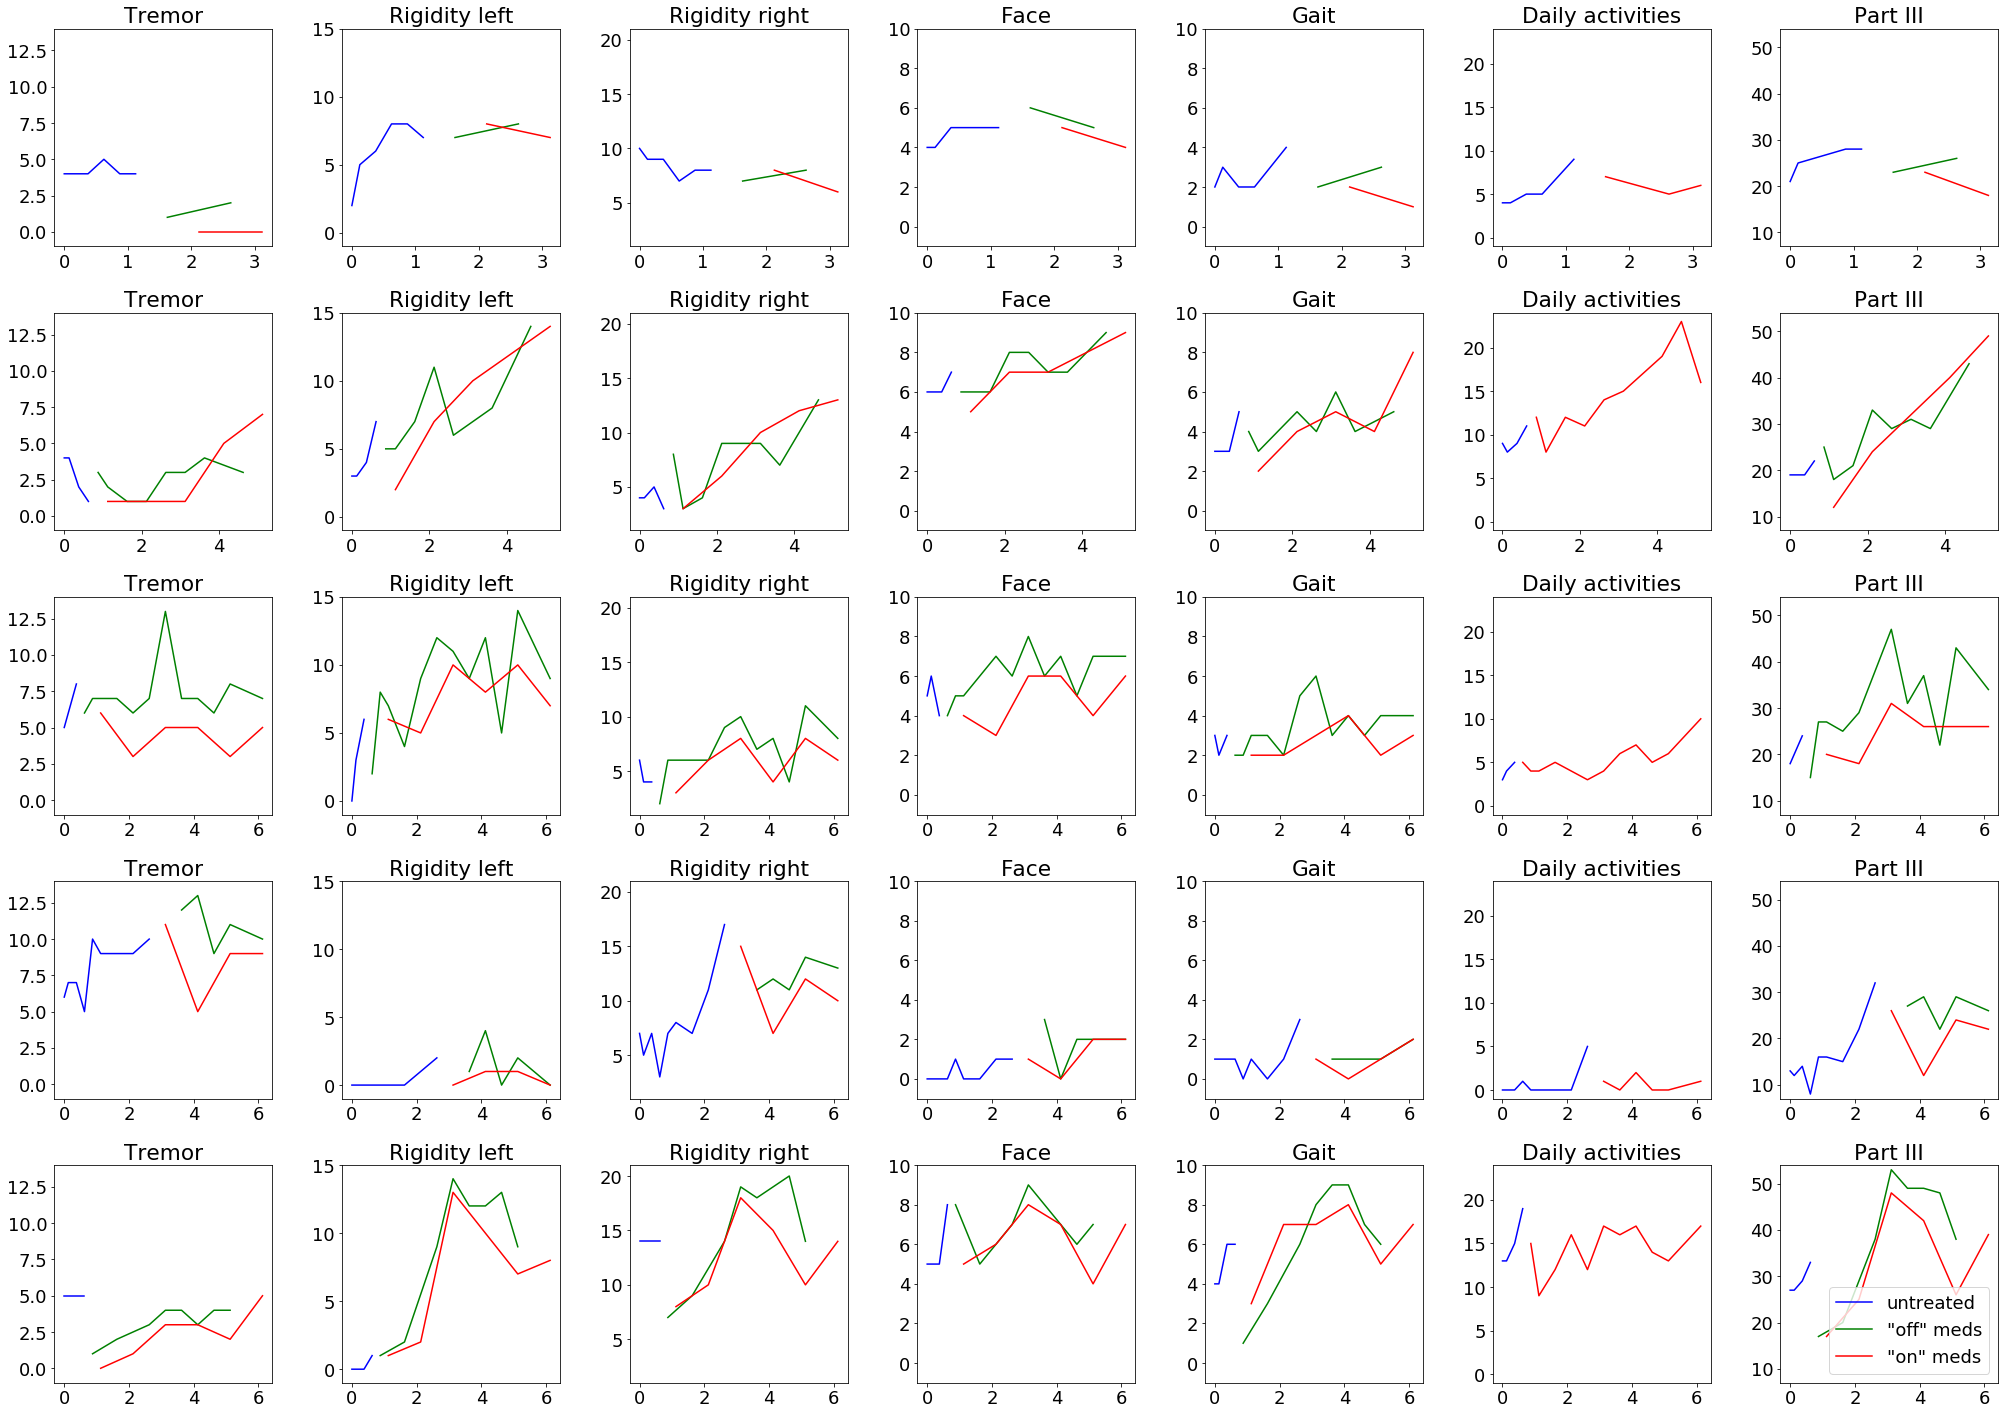

In [26]:
make_mdsupdrs_plot(pd_questions_df)

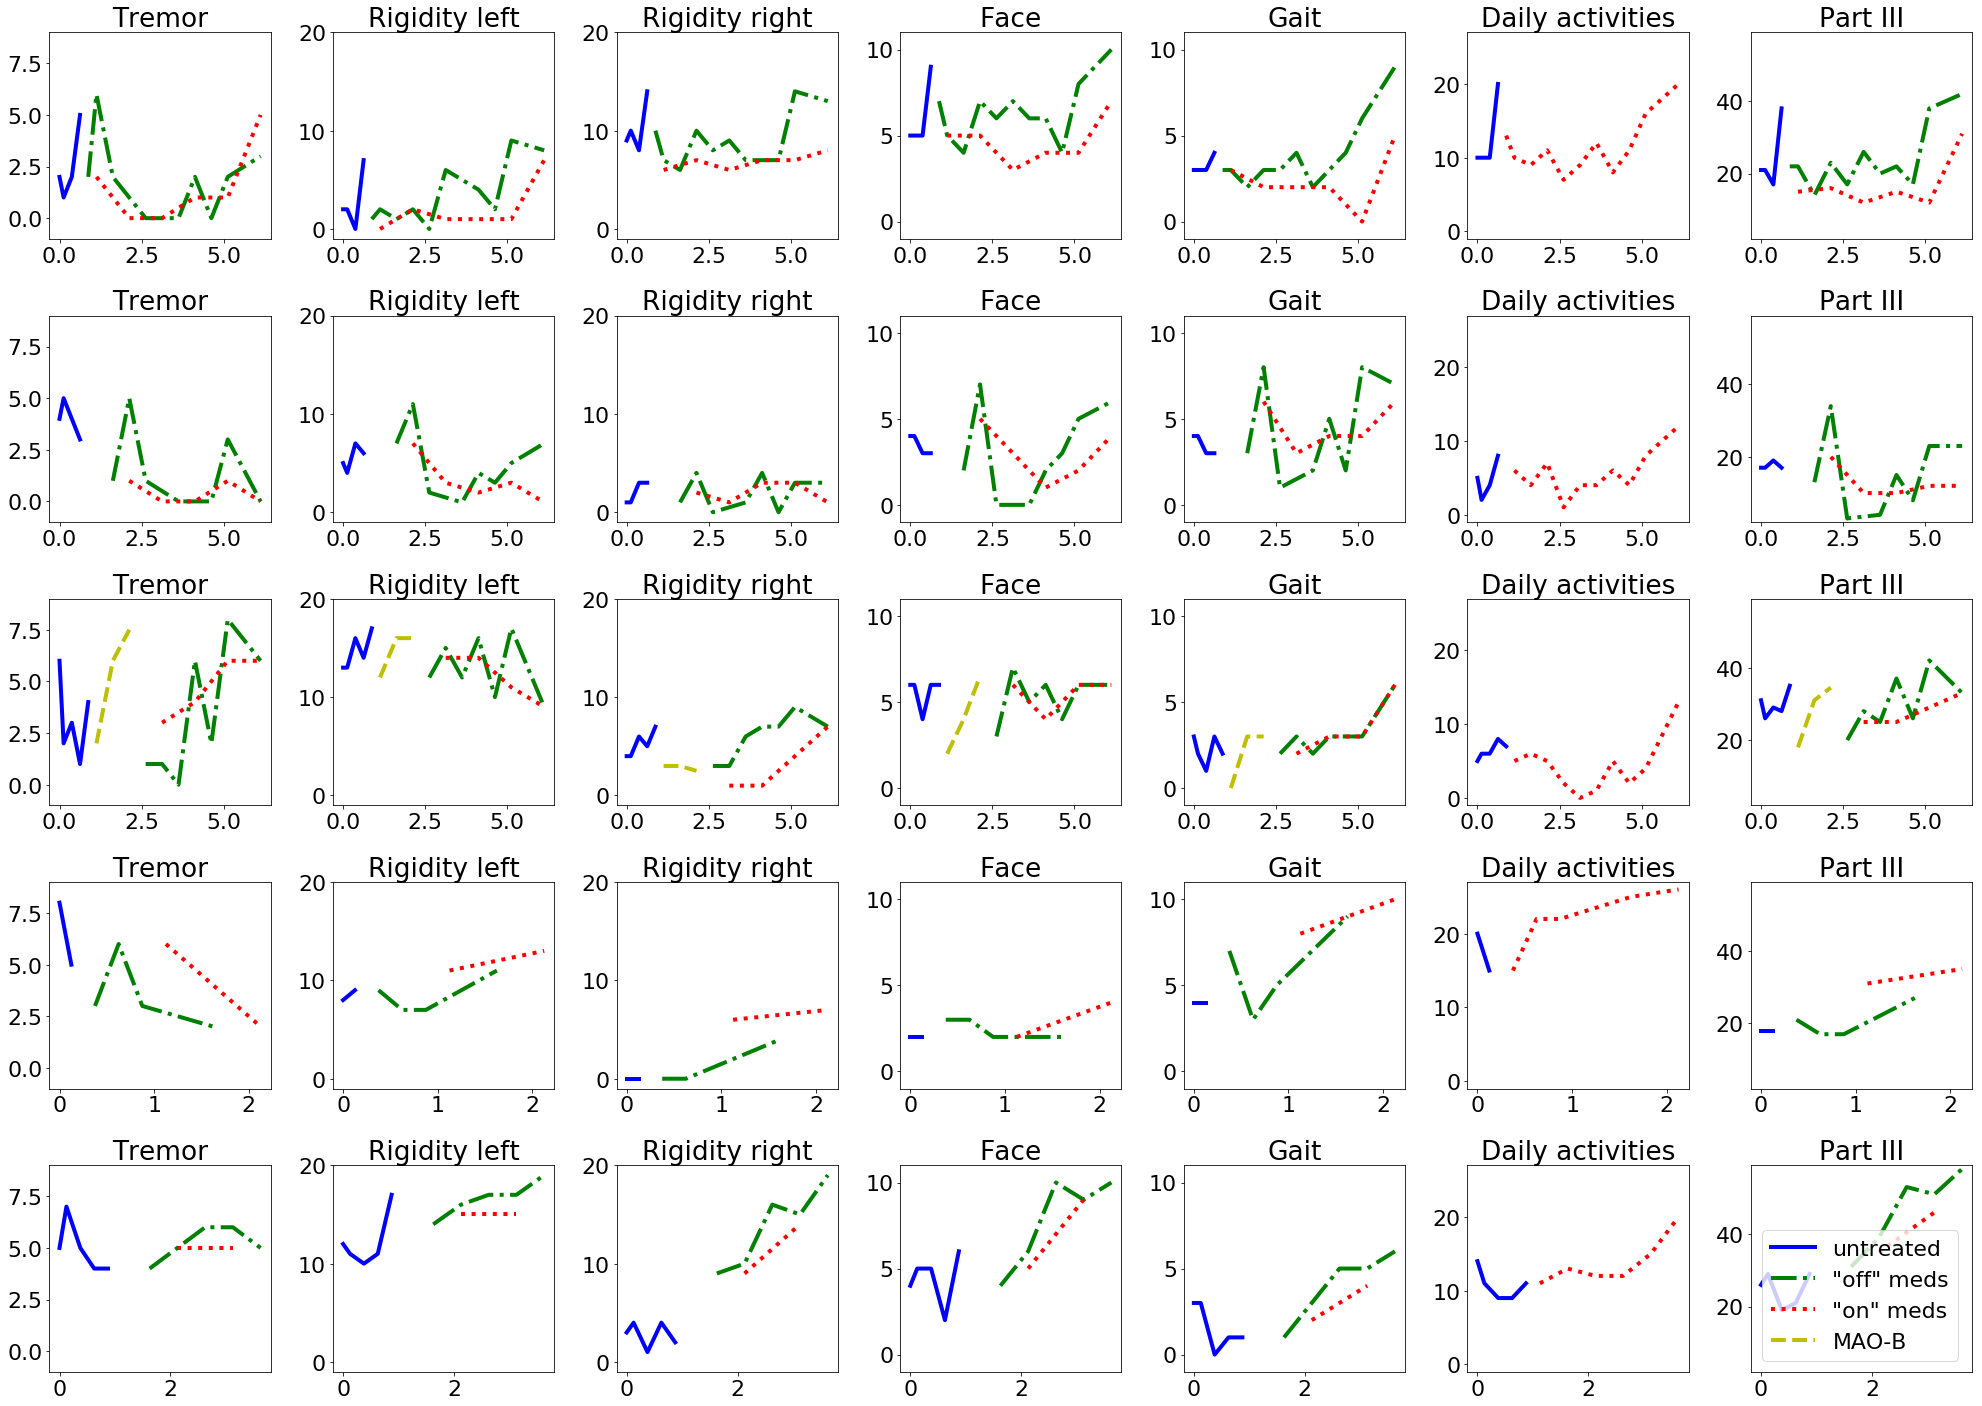

In [14]:
make_mdsupdrs_plot(pd_questions_df, offset=5)